# Importing Libraries <a name="first-bullet"></a>

In [4]:
import pathlib as pl
from bs4 import BeautifulSoup
import re, os, time, string
import unidecode

import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None) ## this is to display the entire dataframe, not just a few rows
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter

# Defining helper functions

The code below is commented out because it was only used to get as complete a list of subjects/disciplines as possible. In the end, it turned out, it was easier to scrape the list of journals that JSTOR keeps and their associated disciplines from JSTOR itself, rather than extracting the subjects from the (not always very reliable and most certainly not complete) metadata of the files we were given access to by JSTOR.
Helper functions defined in a different Jupyter notebook were used for filtering the disciplines from the scraped discipline-journal associations.

In [ ]:
# #code to get as complete a list of the possible subjects as possible

# subj_lst = []
# for file2 in pl.Path(r'C:/Users/jackewiebohne/Documents/python tests/DTA/JSTOR/metadata').iterdir():
#     if file2.is_file():    
#         temp_string = ''
#         with open(file2, encoding='utf8', errors='ignore') as xml:
#             soup = BeautifulSoup(xml, 'lxml')
#             try:
#                 temp_write_string = soup.find('subj-group', {'subj-group-type': "discipline"}).find_all_next('subject')
#                 for i in range(len(temp_write_string)):
#                     subj_lst.append(temp_write_string[i].text)
#             except:
#                 continue

# subj_set = set(subj_lst)
# fields = open('./JSTOR data/fields.txt', 'r', encoding='utf8')
# fields_set = set(fields.read().split('\n'))

# total_set = subj_set.union(fields_set)
# with open('./JSTOR data/disciplines.txt', 'w+', encoding='utf8') as wr:
#     for ele in total_set:
#         wr.write(str(ele) + '\n')
# print(len(subj_set), len(fields_set), len(total_set))

In [ ]:
# it turned out this function was not particularly necessary, but oh well

def file_writer(string_to_write, filename_n_loc, write_method, flush=True):
    with open(filename_n_loc, write_method, encoding='utf8') as wr:
        wr.write(str(string_to_write))
        if flush:
            wr.flush()  # flushing internal buffers
            os.fsync(wr.fileno()) # forcing to write to file

In [ ]:
# a decorator function for timing other operations that are defined and executed below to check for potential bottlenecks etc.

def function_timer(function): # function is a parameter and is the function to be timed
    def wrapper(*inputs): # *inputs are the parameters (of varying length) of the function to be timed
        start = time.time()
        result = function(*inputs)
        end = time.time()
        print('function \"', function.__name__, '\" executed in', end-start, 'seconds')
        return result # returns the result of the timed function
    return wrapper

In [ ]:
def word_counter(wordstring):
    return sum(1 for x in wordstring.split())


def PunctuationRemover(wordstring, return_list=False):
    assert type(wordstring) == str
    a = wordstring
    translator = str.maketrans('', '', string.punctuation)
    g = a.translate(translator)
    h = re.sub('(«|»)', '', g)
    if return_list == True:
        h = h.split()
    return h

In [ ]:
# This function was used to extract n-grams of the keyword of interest ('hustling' and cognates). 
# Note that the function only looks for exact matches and that it does not check for word-onset capitalisation,
# i.e. the list of keywords provided that this function should check for should also include capitalised words

@function_timer
def KeyGram(keyword, wordstring, n_length=10):
    assert type(wordstring) and type(keyword) == str
    lst_removed_punctuation = PunctuationRemover(wordstring, True)
    cache_lst = []
    count_backward = 0
    switch = False
    for index, word in enumerate(lst_removed_punctuation):
        cache_string = ''
        if count_backward == n_length and switch == True:
            cache_string += str(lst_removed_punctuation[index - n_length:index])
            switch = False
            count_backward = 0
        elif switch == True and count_backward < n_length:
            count_backward += 1
        elif word.lower() == keyword.lower():
            # in case string shorter than n_length on either end of the keyword
            if n_length > int(int(len(lst_removed_punctuation[:index]) - 2)) and n_length > int(int(len(lst_removed_punctuation[index:]) - 2)):
                cache_string += str(lst_removed_punctuation)
            # in case string shorter than n_length before the keyword
            elif n_length > int(int(len(lst_removed_punctuation[:index]) - 2)):
                cache_string += str(lst_removed_punctuation[:index]) + ' ' + str([keyword]) + ' '
                switch = True
            # in case string is longer than n_length on either side of keyword
            elif n_length <= int(int(len(lst_removed_punctuation[:index]) - 2)) and n_length <= int(int(len(lst_removed_punctuation[index:]) - 2)):
                cache_string += str(lst_removed_punctuation[index - n_length:index]) + ' ' + str([keyword]) + ' '
                switch = True
            # in case string shorter than n_length after the keyword
            elif n_length > int(int(len(lst_removed_punctuation[index:]) - 2)):
                cache_string += str(lst_removed_punctuation[index+1:])
        cache_string = cache_string.replace('[', '').replace(']', '').replace('\'', '').replace(',', '')
        if cache_string:
            cache_lst.append(cache_string)
    return cache_lst

In [ ]:
import spacy

@function_timer
def named_entity_recog(wordstring):
    """
    requires that spacy is installed and "en_core_web_sm" is downloaded
    outputs a list
    """
    ocr_split = wordstring.split()
    nlp = spacy.load('en_core_web_trf')#("en_core_web_sm")
    ner_data = []
    _words = ''
    if len(ocr_split) >= 100000:
        for word in ocr_split:
            _words += word + ' '
            if len(_words.split()) == 100000:
                for entity in nlp(_words).ents:
                    if entity.label_ == 'NORP' or entity.label_ == 'LOC' or entity.label_ == 'GPE':
                        ner_data.append((entity.text, entity.label_))
                _words = ''

    else:
        for entity in nlp(wordstring).ents:
            if entity.label_ == 'NORP' or entity.label_ == 'LOC' or entity.label_ == 'GPE':
                ner_data.append((entity.text, entity.label_))
    return ner_data

In [ ]:
def get_publisher(soup_object):
    publisher_string = ''
    try:
        publisher_string += soup_object.find('journal-title').text
    except:
        publisher_string += soup_object.find('publisher-name').text
    return publisher_string

In [ ]:
# @function_timer
def get_subject(soup_object, return_of_get_publisher):
    """returns the subject field listed in the metadata. 
    if no subject is given the function searches for subject
    information in the publisher information and compares that with
    a list of subject fields that was filtered in a first run 
    from the metadata"""
    
    fields = open('./JSTOR data/disciplines.txt', 'r', encoding='utf8') ## the disciplines file contains a manually curated list including a list of existing subjects that have been extracted previously from all of the available metadata
#     subject_string = ''
    subj_set = set()
    try:
        temp_string = ''
        temp_write_string = soup_object.find('subj-group', {'subj-group-type': "discipline"}).find_all_next('subject')
        for i in range(len(temp_write_string)):
            subj_set.add(temp_write_string[i].text)
#             subject_string += temp_write_string[i].text + ', '
    except:
        for word in fields.read().split('\n'):
            sm = sum(1 for letter in word)
            for i in range(len(return_of_get_publisher)):
                if word.lower() == return_of_get_publisher[i:i + sm].lower():
                    subj_set.add(word)
#                     subject_string += word + ', '
    subject_string = ', '.join(subj_set)
    return subject_string

In [ ]:
@function_timer
def get_geodata(string):
    countries = open('./JSTOR data/UN_countries.txt', encoding='utf8')
    country_string = ''
    for country in countries.read().split('\n'):
        sm = sum(1 for letter in country)
        for i in range(len(string)):
            if country.lower() in string[i:i + sm].lower() and str(country):
                country_string += str(country)# + ', '
    return country_string

def get_author(soup_object):
    name_string = ''
    surname_lst = []
    givenname_list = []
    temp_name_string = soup_object.find('contrib-group').find_all('surname')
    for i in range(len(temp_name_string)):
        surname_lst.append(temp_name_string[i].text)
    temp_name_string2 = soup_object.find('contrib-group').find_all('given-names')
    for i in range(len(temp_name_string2)):
        givenname_list.append(temp_name_string2[i].text)
    for word in zip(surname_lst, givenname_list):
        name_string += str(word) + ', '
    return name_string


def get_title(soup_object):
    title_string = ''
    try:
        title_string += soup_object.find('book-title').text
        try:
            title_string += '. ' + soup_object.find('subtitle').text
        except:
            pass
    except:
        title_string += soup_object.find('article-title').text
    return title_string


def get_date(soup_object):
    date_string = ''
    date_string += soup_object.find('pub-date').find_next('year').text
    return date_string


# Executing functions and getting some of the data <a name="second-bullet"></a>


## total data (non-OCR and OCR)

In [ ]:
### this cell is to parse the metadata only: there are about 7000 files with hits on hustling
### whose metadata we have. Only about 4000 of those also have OCRed articles/chapters/books
### the OCRed metadata is parsed by the cell below

dfs = 0

filenames = []
author_lst = []
title_lst = []
date_lst = []
publisher_lst = []
subject_lst = []


for file2 in pl.Path(r'C:/Users/jackewiebohne/Documents/python tests/DTA/JSTOR/metadata').iterdir():
    if file2.is_file(): 
        str0 = ''
        temp_string = str(file2)
        forbidden = ['C:', 'Users', 'jackewiebohne', 'Documents', 'python tests', 'DTA', 'JSTOR', 'ocr', 'metadata']
        for ele in temp_string.split('\\'):
            if ele not in forbidden:
                str0 += ele
                str0 = str0.replace('.txt', '')
                filenames.append(str0)
        with open(file2, encoding='utf8', errors='ignore') as xml:
            soup = BeautifulSoup(xml, 'lxml')
            try:
                author_string = get_author(soup)
            except:
                author_string = 'no author'
            author_lst.append(author_string)
#             print(author_lst)
            ###title###
            try:
                title_string = get_title(soup)
            except:
                title_string = None
            _title = PunctuationRemover(str(title_string))
            title_lst.append(_title)
#             print(title_string)
            ###date###
            try:
                date_string = get_date(soup)
            except:
                date_string = None
            date_lst.append(date_string)
#             print(date_lst)
            ###get publisher###
            try:
                publisher_string = get_publisher(soup)
            except:
                publisher_string = None
            _pub = PunctuationRemover(publisher_string)
            publisher_lst.append(_pub)
#             print(publisher_lst)
            ###subject###
            try:
                subject_string = get_subject(soup, publisher_string)
            except:
                subject_string = 'no subject'
            subject_lst.append(subject_string)
#             print(subject_lst)

df0 = pd.DataFrame(list(zip(filenames, author_lst, title_lst, date_lst, publisher_lst, subject_lst)),  columns =['filename', 'author', 'title', 'pub_date', 'publisher', 'subject'])
df0.to_excel('./JSTOR data/total_metadata.xlsx')

Just having a peek at some of the data ...

In [ ]:
df0['subject'].value_counts()[:25]
df0['pub_date'].value_counts()[:25]
df0['publisher'].value_counts()[:25]

## OCRed data (geodata, titles, authors, disciplines, word count etc...)

In [ ]:
###this cell is to parse the OCR & metadata

#declaring variables
file_counter = 0
abs_file_counter = 0
memory_limit = 500
dfs = 0

filenames = []
author_lst = []
title_lst = []
date_lst = []
publisher_lst = []
subject_lst = []
geodata_lst = []
word_count_lst = []


num_files = sum(1 for file in pl.Path(r'C:/Users/jackewiebohne/Documents/python tests/DTA/JSTOR/ocr').iterdir())

# iterating over files
for file in pl.Path(r'C:/Users/jackewiebohne/Documents/python tests/DTA/JSTOR/ocr').iterdir():
#     print('there are '+ str(num_files) + 'files')
    print('progress is ' + str(abs_file_counter/num_files) *100 + '% complete\n\n')
    
    
    string1 = ''
    if file.is_file():
        temp_string = str(file)
        forbidden = ['C:', 'Users', 'jackewiebohne', 'Documents', 'python tests', 'DTA', 'JSTOR', 'ocr', 'metadata']
        for ele in temp_string.split('\\'):
            if ele not in forbidden:
                string1 += ele
                string1 = string1.replace('.txt', '')
        for file2 in pl.Path(r'C:/Users/jackewiebohne/Documents/python tests/DTA/JSTOR/metadata').iterdir():
            string2 = ''
            if file2.is_file():
                temp_string2 = str(file2)
                for ele in temp_string2.split('\\'):
                    if ele not in forbidden:
                        string2 += ele
                        string2 = string2.replace('.xml', '')

        ###find the matching metadata xml###
            if string1 == string2:
                file_counter += 1
                abs_file_counter += 1
                filenames.append(string1)
                print(str(file_counter) + ": " + string1)
                
                #parse xml metadata for peritextual info
                with open(file2, encoding='utf8', errors='ignore') as xml:
                    soup = BeautifulSoup(xml, 'lxml')
                    ###author name###
                    try:
                        author_string = get_author(soup)
                    except:
                        author_string = 'no author'
                    author_lst.append(author_string)
#                     print(author_string)
                    ###title###
                    try:
                        title_string = get_title(soup)
                    except:
                        title_string = None
                    _title = PunctuationRemover(str(title_string))
                    title_lst.append(_title)
#                     print(title_string)
                    ###date###
                    try:
                        date_string = get_date(soup)
                    except:
                        date_string = None
                    date_lst.append(date_string)
#                     print(date_string)
                    ###get publisher###
                    try:
                        publisher_string = get_publisher(soup)
                    except:
                        publisher_string = None
                    _pub = PunctuationRemover(publisher_string)
                    publisher_lst.append(_pub)
#                     print(publisher_string)
                    ###subject###
                    try:
                        subject_string = get_subject(soup, publisher_string)
                    except:
                        subject_string = 'no subject'
                    subject_lst.append(subject_string)
#                     print(subject_lst)
                                        
                #parse OCRed JSTOR docs
                with open(file, encoding='utf8') as ocr:
                    ocr = ocr.read()
                    
                    ###word count###
                    word_count = word_counter(ocr)
                    print("word_count: ", word_count)
                    word_count_lst.append(word_count)
                    
                    ###getting some NER data###
                    try:
                        ner_data = named_entity_recog(ocr)                    
                    except:
                        ner_data = None
                        print('couldn\'t get NER data')
                        continue
                    geodata_lst.append(ner_data)

                    if file_counter == memory_limit:
                        # add to dataframe and write to file
                        print('printing to excel file')
                        dfs += 1
                        df = pd.DataFrame(list(zip(filenames, author_lst, title_lst, date_lst, publisher_lst, subject_lst, word_count_lst, geodata_lst)),  columns =['filename', 'author', 'title', 'pub_date', 'publisher', 'subject', 'word_count', 'geodata'])
    
                        filenames = []
                        author_lst = []
                        title_lst = []
                        date_lst = []
                        publisher_lst = []
                        subject_lst = []
                        geodata_lst = []
                        word_count_lst = []
                        
                        file_counter = 0
                        
                        df.to_excel('./JSTOR data/metadata' + str(dfs) + '.xlsx')
                    
                    ###n-grams of keyword###
                    keywords = ['hustle', 'hustled', 'hustler', 'hustlers', 'hustles','hustling', 'Hustle', 'Hustled', 'Hustler', 'Hustlers', 'Hustles', 'Hustling']
                    keygram_cache = []
                    for keyword in keywords:
                        keygram_cache.append(KeyGram(keyword, ocr, 30))
                
                    #writing to file
                    file_writer(keygram_cache, './JSTOR data/keygrams/'+ str(string1) + '.txt', 'w+')


###flush the remaining memory. if it's below the memory limit it will not have been written to file yet###
print('printing to excel file')
dfs += 1
df = pd.DataFrame(list(zip(filenames, author_lst, title_lst, date_lst, publisher_lst, subject_lst, word_count_lst, geodata_lst)),  columns =['filename', 'author', 'title', 'pub_date', 'publisher', 'subject', 'word_count', 'geodata'])
df.to_excel('./JSTOR data/metadata' + str(dfs) + '.xlsx')


## topgram geodata (1000 most freq hustling OCRed data; geodata parser more powerful than for other OCR)

In [ ]:
file_counter = 0
abs_file_counter = 0
memory_limit = 50
dfs = 0

filenames = []
geodata_lst = []
overflow1 = []
overflow2 = []
overflow3 = []
overflow4 = []

### for faster looping
dftopgram = pd.read_excel('./JSTOR data/topgramOCR.xlsx', engine='openpyxl')
topgram_arr = dftopgram['filename'].values #using numpy arrays
###

### for stop-n-go parsing: to continue from last parsing step
parsed_count = 0
tracker = open('./JSTOR data/keep_count.txt', 'a+')
for line in tracker:
    parsed_count += 1
###

num_files = sum(1 for file in pl.Path(r'C:/Users/jackewiebohne/Documents/python tests/DTA/JSTOR/ocr').iterdir())

# iterating over files
for file in pl.Path(r'C:/Users/jackewiebohne/Documents/python tests/DTA/JSTOR/ocr').iterdir():
    print('progress is ' + str(abs_file_counter/num_files) *100 + '% complete\n\n')
    string1 = ''
    if file.is_file():
        abs_file_counter += 1
        tracker.write(str(parsed_count) + '\n')
        
        ##comparing counters to pick up at last parsed location
        if (parsed_count/memory_limit) <= abs_file_counter/memory_limit:
            ## getting filename and cleaning it for comparison
            temp_string = str(file)
            forbidden = ['C:', 'Users', 'jackewiebohne', 'Documents', 'python tests', 'DTA', 'JSTOR', 'ocr', 'metadata']
            for ele in temp_string.split('\\'):
                if ele not in forbidden:
                    string1 += ele
                    string1 = string1.replace('.txt', '')
                    ## checking if this particular file is in topgram array: if so, spacy's highest quality NER parser will look for geodata
                    if string1 in topgram_arr:
                        filenames.append(string1)
                        file_counter +=1 #for checking memory limit
                        
                        #parse OCRed JSTOR docs
                        with open(file, encoding='utf8') as ocr:
                            ocr = ocr.read()

                            ###getting NER data###
                            try:
                                ner_data = named_entity_recog(ocr)                    
                            except:
                                ner_data = None
                                print('couldn\'t get NER data')
                                continue
                            if len(ner_data) > 430 and len(ner_data) < 860:
                                geodata_lst.append(ner_data[0:430])
                                overflow1.append(ner_data[430:])
                                overflow2.append(np.nan)
                                overflow3.append(np.nan)
                                overflow4.append(np.nan)
                            elif len(ner_data) > 860 and len(ner_data) < 1290:
                                geodata_lst.append(ner_data[0:430])
                                overflow1.append(ner_data[430:860])
                                overflow2.append(ner_data[860:])
                                overflow3.append(np.nan)
                                overflow4.append(np.nan)
                            elif len(ner_data) > 1290 and len(ner_data) < 1720:
                                geodata_lst.append(ner_data[0:430])
                                overflow1.append(ner_data[430:860])
                                overflow2.append(ner_data[860:1290])
                                overflow3.append(ner_data[1290:1720])
                                overflow4.append(np.nan)
                            elif len(ner_data) > 1720 and len(ner_data) < 2150:
                                geodata_lst.append(ner_data[0:430])
                                overflow1.append(ner_data[430:860])
                                overflow2.append(ner_data[860:1290])
                                overflow3.append(ner_data[1290:1720])
                                overflow4.append(ner_data[1720:2150])
                                print('geodata limit exceeded')
                            else:
                                geodata_lst.append(ner_data)
                                overflow1.append(np.nan)
                                overflow2.append(np.nan)
                                overflow3.append(np.nan)
                                overflow4.append(np.nan)
                            if file_counter == memory_limit:
                                # add to dataframe and write to file
                                print('printing to excel file')
                                dfs += 1
                                df = pd.DataFrame(list(zip(filenames, geodata_lst, overflow1, overflow2, overflow3, overflow4)),  columns =['filename', 'geodata_0', 'geodata_1', 'geodata_2', 'geodata_3', 'geodata_4'])

                                geodata_lst = []
                                filenames = []
                                overflow1 = []
                                overflow2 = []
                                overflow3 = []
                                overflow4 = []
                                file_counter = 0

                                df.to_excel('./JSTOR data/topgram_geo' + str(dfs) + '.xlsx')

###flush the remaining memory. if it's below the memory limit it will not have been written to file yet###
print('printing to excel file')
dfs += 1
df = pd.DataFrame(list(zip(filenames, geodata_lst, overflow1, overflow2, overflow3, overflow4)),  columns =['filename', 'geodata_0', 'geodata_1', 'geodata_2', 'geodata_3', 'geodata_4'])
geodata_lst = []
filenames = []
overflow1 = []
overflow2 = []
overflow3 = []
overflow4 = []
tracker.close()

### some peeks at the data

In [ ]:
#filtering out the highest no of hits of the keygrams from the keygram docs
def count_keygrams(keywords, low_limiter=3):
    doc_lst = []
    key_counts = []
    for file in pl.Path(r'./JSTOR data/keygrams/').iterdir():
        counter = 0
        abs_counter = 0
        str1 = ''
        with open(file, encoding='utf8') as f:
            for word in f.read().split():
                for keyword in keywords:
                    if word == keyword:
                        counter += 1
                        abs_counter += 1
            if counter > low_limiter:
                temp_string = str(f)
                forbidden = ['C:', '<_io.TextIOWrapper name=\'JSTOR data', 'Users', 'jackewiebohne', 'Documents', 'python tests', 'DTA', 'JSTOR data', 'ocr', 'metadata', 'JSTOR', 'keygrams']
                for ele in temp_string.split('\\'):
                    if ele not in forbidden:
                        str1 += ele
                        str1 = str1.replace('.txt\' mode=\'r\' encoding=\'utf8\'>', '')
                        if str1:
                            doc_lst.append(str1)
                            key_counts.append(abs_counter)
    return doc_lst, key_counts

In [ ]:
keywords = ['hustle', 'hustled', 'hustler', 'hustlers', 'hustles','hustling', 'Hustle', 'Hustled', 'Hustler', 'Hustlers', 'Hustles', 'Hustling']
docs, counts = count_keygrams(keywords)
assert(len(docs) == len(counts))
# print(docs)


In [ ]:
#finding the metadata of the documents with the highest no of hits of the keygrams from the keygram docs
def top_keygram_mentions(first_count_keygrams_output, dataframe):
    """count_keygrams outputs a tuple, we need the first of the tuple as input"""
    top_keygram_df_lst = []
    for i in range(len(first_count_keygrams_output)):
        for j in range(len(dataframe['filename'])):
            if first_count_keygrams_output[i] == dataframe['filename'].iloc()[j]:
                top_keygram_df_lst.append(dataframe.iloc()[j,:])
    return pd.DataFrame(top_keygram_df_lst)

In [ ]:
topgram = top_keygram_mentions(docs, pd.read_excel(r"C:\Users\jackewiebohne\Documents\python tests\DTA\JSTOR data\OCR_total_metadata.xlsx", engine='openpyxl'))
topgram.insert(3, 'keygram_count', counts)
display(topgram.iloc()[:,1:])
topgram.iloc()[:,1:].to_excel('./JSTOR data/topgramOCR.xlsx')

In [ ]:
##concatenating all the dataframes; they were split in the initial function because of memory
dfs = []
for i in range(1,21):
    df = pd.read_excel(r"C:\Users\jackewiebohne\Documents\python tests\DTA\JSTOR data\topgram_geo" + str(i) +".xlsx", engine='openpyxl')
    dfs.append(df)
    
res = pd.concat([frame for frame in dfs], ignore_index =True)
display(res)
res.iloc()[:, 1:].to_excel('./JSTOR data/topgram_geo.xlsx', index=False)


In [ ]:
# full_set = set(res['geodata_4']) | set(res['geodata_3']) | set(res['geodata_2']) | set(res['geodata_1']) | set(res['geodata_0'])
# # print(full_set)
# for i in full_set:
#     print(i, type(i))

# Loading and Visualising the preliminary Data

In [ ]:
dftotal = pd.read_excel('./JSTOR data/total_metadata.xlsx', engine='openpyxl')
ex = dftotal['pub_date'].value_counts().argmin() # the index to exclude, since there is one file whose date is erroneously given as 90

ystotal = [dftotal['pub_date'].value_counts().iloc()[i] for i in range(len(dftotal['pub_date'].value_counts())) if i != ex] 
xstotal = [dftotal['pub_date'].value_counts().index.tolist()[i] for i in range(len(dftotal['pub_date'].value_counts().index.tolist())) if i != ex]
plt.title('Number of publications per date of total metadata on hustling')
plt.xlabel('Dates')
plt.ylabel('Number of Publications')
plt.scatter(xstotal, ystotal)

In [ ]:
dfOCR = pd.read_excel('./JSTOR data/OCR_total_metadata.xlsx', engine='openpyxl')
ysOCR = dfOCR['pub_date'].value_counts()
xsOCR = dfOCR['pub_date'].value_counts().index.tolist()
plt.title('Number of publications per date of OCRed articles')
plt.xlabel('Dates')
plt.ylabel('Number of Publications')
plt.scatter(xsOCR, ysOCR)

In [ ]:
dftopgram = pd.read_excel('./JSTOR data/topgramOCR.xlsx', engine='openpyxl')
# display(res['subject'].value_counts()[:25])
# display(dfOCR['pub_date'].value_counts().iloc()[:25])
ystopgram = dftopgram['pub_date'].value_counts()
xstopgram = dftopgram['pub_date'].value_counts().index.tolist()
plt.title('Publications per date of articles with\nmost frequent mentions of hustling')
plt.xlabel('Dates')
plt.ylabel('Number of Publications')
plt.scatter(xstopgram, ystopgram)

In [ ]:
# journal_titles = ['Journal of Consumer Research', 'Signs', 'Journal of Near Eastern Studies', 'Ethics', 'Critical Inquiry', 'Classical Antiquity', 'Gastronomica', 'Pacific Historical Review', 'Symbolic Interaction', 'Social Problems', 'The Public Historian', 'The Elementary School Journal', 'Journal of Vietnamese Studies', 'The School Review', 'Phoenix', 'The Tulane Drama Review', 'Child Development', 'The Drama Review TDR', 'PMLA', 'Crime and Justice', 'Foreign Policy', 'The American Economic Review', 'Curriculum Inquiry', 'Winterthur Portfolio', 'Cinema Journal', 'The Russian Review', 'BioScience', 'Journal of Japanese Studies', 'NOVEL A Forum on Fiction', 'The Condor', 'Journal of Mammalogy', 'Modern Judaism', 'The Review of Politics', 'German Studies Review', 'Copeia', 'The Journal of Human Resources', 'Theory Into Practice', 'Dance Research Journal', 'Soviet Studies', 'Design Issues', 'Muqarnas', 'Journal of Herpetology', 'Perspecta', 'Dance Chronicle', 'Leonardo', 'The American Historical Review', 'Daedalus', 'Foreign Affairs', 'Human Studies', 'The China Journal', 'The Southern Literary Journal', 'Victorian Periodicals Review', 'The English Historical Review', 'Mississippi Review', 'Revista de Historia de América', 'The Iowa Review', 'The Reading Teacher', 'The British Medical Journal', 'The Phi Delta Kappan', 'MELUS', 'Perspectives on Politics', 'Oregon Historical Quarterly', 'The Review of Politics', 'Ethnology', 'Family Relations', 'Ethos', 'The Irish Monthly', 'The Lotus Magazine', 'Books Ireland', 'World Affairs', 'The Radical Teacher', 'Prooftexts', 'Utopian Studies', 'American Bar Association Journal', 'October', 'ABA Journal', 'Off Our Backs', 'Journal of Advanced Composition', 'JAC', 'The Journal of Politics', 'Political Science Quarterly', 'The Economic Journal', 'Agni', 'Polity', 'Middle School Journal', 'Letras Femeninas', 'American Periodicals', 'Prairie Schooner', 'Challenge']
# fields = ['Business', 'Gender', 'Middle East', 'Philosophy', 'Cultural', 'History', 'Food Studies', 'History', 'Sociological', 'Social Science', 'History', 'Education', 'Asian Studies', 'Education', 'Classics', 'Literature', 'Psychology', 'Literature', 'Literature', 'Criminology', 'Political', 'Economics', 'Education', 'History', 'Film', 'Slavic', 'Biology', 'Asian', 'Literature', 'Biology', 'Biology', 'Jewish Studies', 'Political', 'Literature', 'Biology', 'Business', 'Education', 'Art', 'History', 'Design', 'Architecture', 'Biology', 'Architecture', 'Art', 'Technology', 'History', 'Art', 'Political', 'Philosophy', 'Asian', 'Literature', 'History', 'History', 'Literature', 'History', 'Literature', 'Education', 'Medical', 'Education', 'Literature', 'Political', 'History', 'Political', 'Cultural', 'Education', 'Psychology', 'Literature', 'Art', 'Literature', 'Political', 'Education', 'Literature', 'Interdisciplinary', 'Law', 'Art', 'Law', 'Gender', 'Rhetoric', 'Rhetoric', 'Political', 'Political', 'Economics', 'Literature', 'Political', 'Education', 'Gender', 'History', 'Literature', 'Economics']

In [ ]:
def normalise(x):
    """
    normalises data by subtracting mean
    and dividing by standard deviation
    input: x should be array
    """
    mean = np.mean(x)
    std = np.std(x)
    return (x-mean)/std

Loading the topgram data

In [ ]:
keygram_count_freqs = dftopgram['keygram_count']/dftopgram['word_count']
datestopgram = dftopgram['pub_date']

In [ ]:
def simple_line(x, a, b):
    return a*x + b

In [ ]:
from scipy.optimize import curve_fit

popt, pcov = curve_fit(simple_line, datestopgram, keygram_count_freqs) # syntax: curve_fit(function, xs, ys) # returns: popt = optimal parameters, pcov = covariance of params

### this was to find the non-value in the array that was wreaking havoc and massively skewed the fit
# print(np.all(np.isfinite(datestopgram)))
# print(np.all(np.isnan(datestopgram)))
# idx = np.where(np.isfinite(datestopgram) == False)
# print(idx)
#####

plt.title('Frequency of mentions of hustling per date\n(only the 1000 articles with most frequent mentions of hustling are shown)')
plt.ylabel('Number of mentions of hustling and cognates\nrelative to word count')
plt.xlabel('Dates')
plt.scatter(datestopgram, keygram_count_freqs)
plt.plot(datestopgram, simple_line(datestopgram, *popt),'r--' , label=('linear regression fit: a=%8f, b=%8f' %tuple(popt))) # *popt unpacks the array
plt.legend()

continue here

In [ ]:
### plotting more recent dates vs frequencies of occurrences of cognates of hustling in the OCRed articles
# previous cell loading the variables needs to be run for this to work

recent_dates_bool = dftopgram['pub_date'] >= 1950 # boolean array with dates more recent than 1950

idxs = dftopgram[datestopgram & recent_dates_bool].index # returns the indexes of the dates given that they are more recent than 1950 # syntax for conditional slicing in pandas: dataframe[cond_1 & ... & cond_n]

recent_freqs = dftopgram['keygram_count'].iloc()[idxs]/dftopgram['word_count'].iloc()[idxs]
recent_dates = dftopgram['pub_date'].iloc()[idxs]


norm_freqs = normalise(recent_freqs)

popt, pcov = curve_fit(simple_line, recent_dates, norm_freqs) # syntax: curve_fit(function, xs, ys) # returns: popt = optimal parameters, pcov = covariance of params
plt.plot(recent_dates, simple_line(recent_dates, *popt),'r--' , label=('linear regression fit: a=%8f, b=%8f' %tuple(popt))) # *popt unpacks the array

plt.title('Frequency per Date of OCRed Hustling Metadata\nfrom 1950 to present')
plt.ylabel('Frequency of Cognates of "Hustling"\nRelative to Word Count (normalised)')
plt.xlabel('Dates')
plt.scatter(recent_dates, norm_freqs)
plt.legend()

# Loading & cleaning

## pre-processing geodata from geonames.org to compare against NER geodata from the top OCRed data

### having a look at the unique geodata contained in the parsed top-1000 OCR docs with mentions of hustling

In [ ]:
#getting unique geodata, just for an idea of the range that's covered
geodata_set = set()
for i in range(len(geodata)):
#     print('i',i)
    for k in range(len(geodata.iloc()[0, -5:])):
        try:
            for j in range(len(eval(geodata.iloc()[i,k]))):
                try:
                    geodata_set.add(eval(geodata.iloc()[i,k])[j])
                except:
                    print('second except')
                    print(geodata.iloc()[i,k])
        except:
            continue
#             print('1st exception')
#             print(geodata.iloc()[i,k])

        
geodata_menge = set()
for ele in geodata_set:
    if ele[1] != 'NORP':
        geodata_menge.add(ele[0])

In [ ]:
print(len(geodata_menge))

for ele in geodata_menge:
#     print(ele)
    file_writer(str(ele) + '\n', './JSTOR data/unique_geodata.txt', 'a') #file_writer(string_to_write, filename_n_loc, write_method

In [ ]:
to_scrap = ['the United States Supreme Court\’s', 'Tabooed','Rembrandt', 'D.C.D.C.', 'the Arrowwood Riding Stables', 'Hotmail',
'Pornography','Baptist', 'Dolly Rathebe', 'Documents','Congressional', 'Republican', 'Democrats', 'Consciousness','Youth Center', 'the United States Sentencing Commission', 'Chaplinesque', 'Theresa', 'Poem', 'OOONOOONOOOONOONO', 'Yeats', 'the United States Army Corps of Engineers', 
'New Ne', 'Bulletin', 'centuries</page><page','Camus','East', 'Clyde','W.J.','News','Weber', 'Capital Punishment', 'the Jersey Lottery', 'Modern Democracy', 'the United States Customs Service\'s', 'Survival','Formalism',
'the Gangster Disciples', 'Mercy','Mumbo Jumbo CI972','Machiavellian', 'Hamlet', 'Page', 'Michelle', 'Ulrich', 'Newton', 'the United States Treasury', 'Horizontal Orbit','Ragtime', 'L Evan', 'Towns', 'Birth of a Nation', 'Harlem hustler', 'Sc',
'Modern Language', 'B.', 'N.Y.U.L.','Cue','Queer', 'Srst','Swine','Ph.D.','Suicide', 'W. Client', 'Nystrom','Mountain', 'Sugar', 'Liver', 'Royal', 'R.', 'Appendix', 'Armstrong', 'Appendicitis', 'Autobiography','Bilingual', 
'Hamilton', 'Manhood','Nineteenth','Queer', 'Crime and Public Policy', 'Day', 'Problem', 'Christianity', 'Christian', 'the United States Constitution', 'n.s','Skyline','PUNISHMENT','Research',  'Utopian','THE RIGHTEOUS DOPE',
'Atlantic Monthly' ,'Manhood', 'Fifties', 'Physician', 'Postmodern', 'Postmodern Drama', 'Lewis Carroll\'s', 'Amendment','Everest','Simpson','Experimental Design','Social', 'Black Invisibility',
'Sons','Al', 'S.M.', 'X.', 'J. D.','PARENT', 'Hans', 'Progress', 'Diane', 'ZZ', 'Quest','Recent', 'Euphoria', 'Addicted Families','Lonely Planet','Contact',
'S.P.', 'Outlaw','Wasteland','New','Maples','Transforming', 'lOjuin', 'Vexed', 'Fremdworten', 'College', 'Lake', 'Cold Mountain','Vicinity','B.O.',
'Masseuses', 'Oeuvres', 'Queer Racisms', 'Hispanic America', 'Junkie','Oil','Erasmus','Schulz','Rose','Offen barung','Ursula',
'M. Klein','McClain','K.Hince','St. Mary\'s College','Deep Down','Documents','Green Bay Packer', 'Locke','Colorado Springs','Hartnagel', 'Autumn','Pyrrhic Victory', 'Armstrong',
'an Indian Portrayed','Career', 'Frost', 'Paper', 'Underemployment', 'Husserl','\uf731\uf738\uf737\uf730s', 'Andreas Kappeler','Ver','Wolfinger','West ern', 'Independence', 'Divine','François Ozon \'s', 'a.k.a', 'Fifteenth Amendments']
to_scrap_n = [str(ele + '\n') for ele in to_scrap]

## to scrap if it contains any of the following characters
forbidden_chars = '<>:;!/{}[]()%$#@*&~|^-•■«?=+$1234567890'

##remove all articles ## remove possessives ## remove all capitalisation
articles = ['the ', ' the ', 'this ']# 'a ', ' a ']
# card_dir = ['north', 'North', 'South', 'south', 'East', 'east', 'West', 'west']

#normalise the names as much as possible # this should run on the geodata in the excel AND the cleanup file
convert_dict_temp = {'Broadway': 'New York City','the United States':'United States', 'D.C.': 'Washington', 'Washington D.C.': 'Washington', 'D. C.': 'Washington', 'New York:': 'New York City','Puerto Rican': 'Puerto Rico',
           'West Oakland' : 'Oakland', 'East Oakland': 'Oakland', 'Addis Ababa.2':'Addis Ababa', 'the United States 8)': 'United States','the Dominican Republic.</p>': 'Dominican Republic', 'South-West Africa': 'South_West Africa',
           'Belfast.58 Much': 'Belfast','Sino-Vietnamese': 'Sino Vietnamese','Georgia 31207</page><page': 'Georgia', 'Miami-Dade Community': 'Miami', 'Afro-European': 'African European',
           'Indian-American': 'Indian American', 'New York 2005': 'New York City', 'Anglo-American': 'Anglo American', 'Saint-Germain-des-Prés': 'Saint_Germain', 'Gafsa city centre.4': 'Gafsa',
           '1900 Belgian': 'Belgian', 'Judeo-Christian': 'Judeo Christian', 'African-American': 'African American','Latin-Caribbean':'Latin Caribbean','West Africa.9': 'West Africa',
           'pan-Caribbean': 'Caribbean', 'Texas?a': 'Texas','Hollywood”;12':'Hollywood', 'Senegalese Mbalax8': 'Senegalese', 'The City as Barracks: Freetown': 'Freetown',
           'Washington DeLora': 'Washington','The City of Chicago':'Chicago', 'the United States Traditionally': 'United States', 'U. S. A' : 'United States', 
           'U.S.A': 'United States', 'U.S.': 'United States', 'N.Y.C': "New York City", 'N.Y.': "New York City", 'U. S.': 'United States','the Caribbean 99': 'Caribbean',
           'Caribbean-American':'Caribbean American', 'post-Egytpian': 'Egyptian', 'St. Kitts-Nevis':'Saint Kitts and Nevis', 'Los Angeles.25': 'Los Angeles',
           'New York City (': 'New York City','Afro-Jamaicans': 'Afro Jamaican', 'Intra-Caribbean': 'Caribbean', 'Latin-African': 'Latin African',
           'Saint-Etienne': 'Saint_Etienne', 'Filipino-Americans': 'Filipino American','pan-African': 'pan African','Afro-Brazilian': 'Afro Brazilian', 'The Gambia' : 'The_Gambia', 'the Gambia': 'The_Gambia',
           'New York:': 'New York City','Japanese-Americans': 'Japanese American', 'Japanese-American':'Japanese American', 'Japan.15 US': 'Japan',
           'Franco-American': 'Franco American','European-American':'European American', 'California 94720': 'California', 'the Soviet Union - the': 'Soviet Union', 'Caribbean Territories': 'Caribbean',
           'the Federal Republic of Germany': 'Germany', 'Quebec City': 'Quebec', 'U.K.': 'United Kingdom', 'Tel Aviv Univer':'Tel Aviv', 'United States of America': 'United States', 
           'N.Y.': 'New York City', 'SOUTH CAROLINA Arose': 'South Carolina','South Central L.A': 'Los Angeles', 'South L.A.': 'Los Angeles', 'Ala.' : 'Alabama',
           'North Ameri-': 'North America', 'New York City\'s': 'New York City', 'Minneap': 'Minneapolis', 'Ore.': 'Oregon', 'Ark.':'Arkansas'}


convert_dict = {}
for key, value in convert_dict_temp.items():
    convert_dict[key.replace('\n', '')] = value
# print(convert_dict.items())


convert_dict_n = {}
for key, value in convert_dict_temp.items():
    convert_dict_n[key.replace('\n', '') + '\n'] = value
# print(convert_dict_n.items())

In [ ]:
states = pd.read_csv('./JSTOR data/US states.txt')
US_states = {}
for i in range(len(states)):
    US_states[states['Ab1'].iloc()[i]] = states['State'].iloc()[i]
    US_states[states['Ab2'].iloc()[i]] = states['State'].iloc()[i]

In [ ]:
countries = open('./JSTOR data/UN_countries.txt', 'r').read().split('\n')
city_country_df = pd.read_csv('./JSTOR data/1k_cities_countries.txt')
for _ in countries:
    file_writer(str(_) + '\n', './JSTOR data/geo_compare.txt', 'a')
for i in range(len(city_country_df)):
    file_writer(str(city_country_df['City'].iloc()[i]) + '\n', './JSTOR data/geo_compare.txt', 'a')

In [ ]:
### cleaning up the data
geo_set = set()
with open('./JSTOR data/unique_geodata.txt', 'r', encoding='utf8') as r_geodata:
    for line in r_geodata:
        skip_line = False
        if line not in to_scrap_n and line not in to_scrap:
            for ele0 in line:
                if ele0 in forbidden_chars:
                    skip_line = True
                    break
        
        if skip_line == False and line not in to_scrap_n and line not in to_scrap:
            geo_set.add(line.replace('\n', ''))
print(len(geo_set))
# print(geo_set)

In [ ]:
geo_set_revised = set()
for ele in geo_set:
    skip = False
    for key0, val0 in convert_dict.items():
        if ele.islower():
            skip=True
            break
        if ele == key0:
            geo_set_revised.add(val0)
            skip = True
            break
    for key, val in convert_dict_n.items():
        if ele.islower():
            skip=True
            break
        if ele == key:
            geo_set_revised.add(val)
            skip = True
            break
    for key1,val2 in US_states.items():
        if ele == key1:
            geo_set_revised.add(val2)
            skip=True
            break
    if skip == False:
        if ele[:4].lower() in articles:
            geo_set_revised.add(ele[4:])#.lower())
        elif ele[:5].lower() in articles:
            geo_set_revised.add(ele[5:])#.lower())
        elif ele[-2:].lower() == '\'s': #checking for possessives
            geo_set_revised.add(ele[:-2])
        else:
            geo_set_revised.add(ele)#.lower())
# print(geo_set_revised)
print(len(geo_set_revised))
            
for ele in geo_set_revised:
#     print(ele)
    file_writer(str(ele) + '\n', './JSTOR data/unique_geodata_clean.txt', 'a') #file_writer(string_to_write, filename_n_loc, write_method
    

cleaned_geo = open ('./JSTOR data/unique_geodata_clean.txt', 'r', encoding='utf8').read().split('\n')

geo_cleaner = set()
for ent in cleaned_geo:
    if ent in countries:
        geo_cleaner.add(ent)
    else:
        for i in range(len(city_country_df)):
            if city_country_df['City'].iloc()[i] == ent:
                geo_cleaner.add(ent)
print(len(geo_cleaner))

for ent2 in geo_cleaner:
    file_writer(str(ent2) + '\n', './JSTOR data/unique_geodata_clean2.txt', 'a')

### pre-pre-processing lists to compare against: 

getting large lists of geodata and combining them so that we have as complete as possible a dataframe with the following columns: districts, cities, countries

this is then compared against the geodata parsed from the top-1000 OCRed documents with most frequent mentions of hustling

In [ ]:
# # dataframe with countries and their associated capitals

# country_df = pd.read_csv('./JSTOR data/countryInfo.txt', sep='\t') # moved to obs folder
# country_df = country_df.iloc()[:,4:6]
# country_df.columns = ['country', 'capital']

# #systematising spelling a bit
# for ir in country_df.itertuples(): # itertuples iterates with a tuple, where: (index, row); hence the index can be accessed with ir[0]
#         try:
#             country_df['capital'][ir[0]] = country_df['capital'][ir[0]].replace('_', ' ')
#         except:
#             continue

# country_df.to_excel('./JSTOR data/capital_country.xlsx')

#cleaned-up country-capital dataframe
country_df = pd.read_excel('./JSTOR data/general_geo/capital_country.xlsx', engine='openpyxl').iloc[:,1:]

In [ ]:
# # dataframe with 1169 most populous cities and their corresponding countries

# cty = pd.read_csv('./JSTOR data/1k_cities_countries.txt') #moved to obs folder

# #systematising spelling a bit
# for ir in cty.itertuples(): # itertuples iterates with a tuple, where: (index, row); hence the index can be accessed with ir[0]
#         try:
#             cty['city'][ir[0]] = cty['city'][ir[0]].replace('_', ' ')
#         except:
#             continue
# cty.to_excel('./JSTOR data/top1000_cities.xlsx')

##cleaned-up top-1000 most populous cities with country dataframe
cty=pd.read_excel('./JSTOR data/general_geo/top1000_cities.xlsx', engine='openpyxl').iloc[:,1:]

In [ ]:
# # dataframe with 24000 city-districts and their corresponding cities

# header= ['geonameid', 'name', 'asciiname', 'alternatenames', 'latitude','longitude', 'feature class','feature code','country code',
# 'cc2','admin1 code','admin2 code','admin3 code','admin4 code','population','elevation','dem','timezone','modification date']
# geonames = pd.read_csv('./JSTOR data/cities15000.txt', sep='\t', names=header) #file has moved to obs
# # display(geonames)

# names = geonames.iloc()[:, 1]
# loc = geonames.iloc()[:, -2]

# names_lst = [el for el in names]
# _loc_lst = [el.split('/') for el in loc]
# continent = [el[0] for el in _loc_lst]
# loc_lst = [el[-1] for el in _loc_lst]

# df2 = pd.DataFrame(list(zip(names_lst,loc_lst)),  columns =['sub_city', 'city'])

# #inserting a new column for country
# df2.insert(2, 'country', [None for i in range(len(df2))])

# #systematising spelling a bit
# for ir in df2.itertuples(): # itertuples iterates with a tuple, where: (index, row); hence the index can be accessed with ir[0]
#     if df2['city'][ir[0]] == 'New_York':
#         df2['city'][ir[0]] = 'New York City'
#     else:
#         try:
#             df2['city'][ir[0]] = df2['city'][ir[0]].replace('_', ' ')
#         except:
#             continue

# df2.to_excel('./JSTOR data/general_geo/districts_cities_countries.xlsx')

## cleaned-up district city dataframe

# df2 = pd.read_excel('./JSTOR data/general_geo/districts_cities_countries.xlsx', engine='openpyxl')

below are just some experiments on how to loop over and compare data more quickly

In [ ]:
###this was a toy example. crucial is that the df2 against which df1 is compared doesn't contain duplicate cities, 
###because it canot contain a duplicate index for this method to work

# df1 = pd.DataFrame({'city': ['New York City', 'Los Angeles', 'Paris', 'Paris', 'Berlin', 'Beijing'], 
#                      'country' : [None, None, None, None, None, None] })

# df2 = pd.DataFrame({'city' : ['New York City','New York City', 'Paris', 'Berlin', 'Beijing', 'Los Angeles', 'Rome'],
#                     'country': ['USA', 'USA','France', 'Germany', 'China', 'USA', 'Italy']})
# df3 = df2.drop_duplicates(subset = 'city')
# df1['country'] = df1.set_index('city')['country'].fillna(df3.set_index('city')['country']).reset_index(drop=True)
# df1

the cell below does the same as the following, just much much faster:
<br>
df = df2.copy()
<br>
for ir in df.itertuples():
>    skip = False
>>    for ir2 in country_df.itertuples():
>>>        if df['city'][ir[0]] == country_df['capital'][ir2[0]]:
>>>>            df['country'][ir[0]] = country_df['country'][ir2[0]]
>>>>            skip = True
>>>>            break  


>if skip==False:
>>        for ir3 in cty.itertuples():
>>>            if df['city'][ir[0]] == cty['Country'][ir3[0]]:
>>>>                df['country'][ir[0]] = cty['Country'][ir3[0]]
>>>>                break

In [ ]:
# #first we need to remove duplicates, because to setting anything as index we cannot have duplicates
# df = df2.copy()
# unique_country_df = country_df.drop_duplicates(subset='capital') #removing duplicates for setting cities as index
# unique_cty = cty.drop_duplicates(subset='City')

# #the below fills the column df['country'] by setting the df's index to city and filling in 
# #the N/A values in the column ['country'] with the country listed in the other df (=unique_country_df) where it has
# # the same city as index. finally it resets the index and drops the old index

# df['country'] = df.set_index('city')['country'].fillna(unique_country_df.set_index('capital')['country']).reset_index(drop=True)
# df['country'] = df.set_index('city')['country'].fillna(unique_cty.set_index('City')['Country']).reset_index(drop=True)
# # display(df)

# df.to_excel('./JSTOR data/general_geo/districts_cities_countries.xlsx')

In [ ]:
df_cf = pd.read_excel('./JSTOR data/general_geo/districts_cities_countries.xlsx', engine='openpyxl').iloc[:,1:]
df_cf.isna().sum() ## 1133 countries are missing for their respective cities 

In [ ]:
df_cf2 = df_cf[df_cf['country'].isnull()] ## getting all the cities whose countries were missed

print(len(df_cf2['city'].unique()))
display(df_cf2.iloc[:,1:])

In [118]:
# filling out cities without corresponding countries manually
conversion_city_country = {'city': ['Andorra', 'Antigua','Tirane','Tucuman','Ushuaia', 'Catamarca', 'Jujuy', 'San Luis',
                                   'Rio Gallegos', 'La Rioja', 'Darwin', 'Hobart', 'Broken Hill', 'Aruba', 'Barbados',
                                   'Bahrain', 'St Barthelemy', 'Bermuda', 'Brunei', 'Kralendijk', 'Santarem',
                                    'Bahia','Araguaina', 'Rio Branco', 'Eirunepe', 'Boa Vista', 'Belize', 'Halifax',
                                    'St Johns', 'Moncton', 'Dawson Creek', 'Glace Bay', 'Regina', 'Thunder Bay',
                                    'Whitehorse', 'Yellowknife', 'Blanc-Sablon', 'Cocos', 'Rarotonga', 'Punta Arenas',
                                    'Costa Rica', 'Cape Verde', 'Curacao', 'Christmas', 'Famagusta', 'Dominica', 'El Aaiun',
                                    'Canary', 'Ceuta', 'Fiji', 'Pohnpei', 'Faroe', 'Grenada', 'Guernsey', 'Godthab',
                                    'Guadeloupe', 'South Georgia', 'Guatemala', 'Guam', 'Guyana', 'Jayapura',
                                    'Isle of Man', 'Jamaica', 'Comoro', 'St Kitts', 'Kuwait', 'Cayman',
                                    'Aqtau','Aqtobe','Atyrau', 'Oral', 'Qyzylorda', 'Qostanay', 'St Lucia', 
                                    'Hovd', 'Choibalsan', 'Macau', 'Martinique', 'Montserrat', 'Malta', 'Mauritius',
                                    'Maldives', 'Blantyre', 'Mazatlan', 'Ojinaga', 'Bahia Banderas', 'Norfolk', 'Nauru',
                                    'Niue', 'Panama', 'Tahiti', 'Bougainville', 'Miquelon', 'Pitcairn', 'Puerto Rico',
                                    'Hebron', 'Madeira', 'Azores', 'Palau', 'Qatar', 'Reunion', 'Kaliningrad', 'Yakutsk',
                                    'Chita', 'Kamchatka', 'Sakhalin', 'Magadan', 'Guadalcanal', 'Mahe', 'St Helena',
                                    'El Salvador', 'Lower Princes', 'Grand Turk', 'Ndjamena', 'Kerguelen', 'Tongatapu',
                                    'Dar es Salaam', 'Simferopol', 'Uzhgorod', 'Zaporozhye', 'Vincennes', 'Menominee', 'Juneau',
                                    'Boise', 'New Salem', 'Honolulu', 'Anchorage', 'Vatican', 'St Vincent',
                                    'Tortola', 'St Thomas', 'Ho Chi Minh', 'Efate', 'Wallis', 'Mayotte', 
                                    'Anguilla', 'Jersey'
                                   ],
             'country': ['Andorra','Antigua','Albania','Argentina', 'Argentina', 'Argentina', 'Argentina', 'Argentina',
                        'Argentina', 'Spain', 'Australia', 'Australia', 'Australia', 'Netherlands overseas', 'Barbados',
                        'Bahrain', 'France overseas', 'United Kingdom overseas', 'Brunei', 'Netherlands overseas', 'Brazil',
                         'Brazil', 'Brazil', 'Brazil', 'Brazil', 'Brazil', 'Belize', 'Canada',
                         'Canada', 'Canada', 'Canada', 'Canada', 'Canada', 'Canada',
                         'Canada', 'Canada', 'Canada', 'Australia', 'Cook Islands', 'Chile',
                         'Costa Rica', 'Cape Verde', 'Curacao', 'Australia', 'Cyprus', 'Dominica', 'Western Sahara',
                         'Spain', 'Spain', 'Fiji', 'United States overseas', 'Denmark overseas', 'Spain', 'United Kingdom', 'Denmark overseas',
                         'France overseas', 'United Kingdom overseas', 'Guatemala', 'United States overseas', 'Guyana', 'Indonesia',
                         'United Kingdom', 'Jamaica', 'Comoros', 'St Kitts', 'Kuwait', 'United Kingdom overseas',
                         'Kazakhstan', 'Kazakhstan','Kazakhstan','Kazakhstan','Kazakhstan','Kazakhstan','St Lucia',
                         'Mongolia', 'Mongolia', 'China', 'France overseas', 'United Kingdom overseas', 'Malta', 'Mauritius',
                         'Maldives', 'Malawi', 'Mexico', 'Mexico', 'Mexico', 'United Kingdom', 'United States overseas',
                         'Niue', 'Panama', 'Tahiti', 'Papua New Guinea', 'France overseas', 'United Kingdom overseas', 'Puerto Rico',
                         'Palestine', 'Portugal', 'Portugal', 'Palau', 'Qatar', 'France overseas', 'Russia','Russia',
                         'Russia', 'Russia', 'Russia', 'Russia', 'Papua New Guinea', 'Seychelles', 'United Kingdom overseas',
                         'El Salvador', 'Netherlands', 'Turks and Caicos Islands', 'Chad', 'France overseas', 'Tonga',
                         'Tanzania', 'Ukraine', 'Ukraine', 'Ukraine', 'France', 'United States', 'United States',
                         'United States', 'United States', 'United States', 'United States', 'Vatican', 'St Vincent and the Grenadines',
                         'United Kingdom overseas', 'United States overseas', 'Vietnam', 'Vanuatu', 'France overseas', 'France overseas',
                         'United Kingdom overseas', 'United Kingdom'
                        ]
             }
# print(len(conversion_city_country['city']), len(conversion_city_country['country']))
city_country_conv_df = pd.DataFrame(conversion_city_country)
# display(city_country_conv_df)
# remove 'Sydney' from sub_city; or rather check if 1k most populous cities are in sub_cities and if those then match their cities, if not, replace by the 1k most populous city/sub_city
# do the same with capitals, run capitals first since it's more important that the 1k most pop. cities are good and they might override capital data

In [ ]:
df_cf['country'] = df_cf.set_index('city')['country'].fillna(city_country_conv_df.set_index('city')['country']).reset_index(drop=True)
# display(df_cf)

# df_cf['country'].isnull().sum()
# df_cf2 = df_cf[df_cf['country'].isnull()]
# display(df_cf2)

# df_cf.to_excel('./JSTOR data/general_geo/districts_cities_countries2.xlsx')
# display(country_df['capital'])

In [ ]:
df_cf = pd.read_excel('./JSTOR data/general_geo/districts_cities_countries2.xlsx', engine='openpyxl').iloc[:,2:]
# display(df_cf)

In [ ]:
len(df_cf)

In [ ]:
#adding top 1k cities and all capitals to total
country_df.rename(columns={'capital':'city'}, inplace=True)
cty.rename(columns={'City':'city', 'Country':'country'}, inplace=True)

_tmp1 = []
_tmp2 =[]
for ir in country_df.itertuples():
    if country_df['city'].iloc[ir[0]] not in df_cf['city'].values:
        _tmp1.append(country_df['city'].iloc[ir[0]])
        _tmp2.append(country_df['country'].iloc[ir[0]])
_df = pd.DataFrame(list(zip(_tmp1, _tmp2)), columns=['city', 'country'])
df_cf = pd.concat([df_cf, _df])
print(len(df_cf))

_tmp1 = []
_tmp2 =[]
for ir in cty.itertuples():
    if cty['city'].iloc[ir[0]] not in df_cf['city'].values:
        _tmp1.append(cty['city'].iloc[ir[0]])
        _tmp2.append(cty['country'].iloc[ir[0]])
_df = pd.DataFrame(list(zip(_tmp1, _tmp2)), columns=['city', 'country'])
df_cf = pd.concat([df_cf, _df])
print(len(df_cf))
df_cf.reset_index(inplace=True)

In [ ]:
#removing all districts that have the same name as capitals or the most populous 1k cities
count1=0
for ir in df_cf.itertuples():
    if df_cf['sub_city'].iloc[ir[0]] in cty['city'].values:
        count1+=1
#         print(df_cf['sub_city'].iloc[ir[0]])
        df_cf['sub_city'].iloc[ir[0]] = None
print(count1)
        
count2=0
for ir in df_cf.itertuples():
    if df_cf['sub_city'].iloc[ir[0]] in country_df['city'].values:
        count2+=1
#         print(df_cf['sub_city'].iloc[ir[0]])
        df_cf['sub_city'].iloc[ir[0]] = None
print(count2)

In [ ]:
print(len(df_cf))

In [ ]:
df_cf = df_cf.iloc[:,1:]
df_cf.to_excel('./JSTOR data/general_geo/districts_cities_countries3.xlsx')

Now the next step:
if any df total cities match 1k cities or capitals but not their countries then those df total cities are removed

In [ ]:
df_cf = pd.read_excel('./JSTOR data/general_geo/districts_cities_countries3.xlsx', engine='openpyxl')

In [ ]:
for ir in df_cf.itertuples():
    for ir2 in country_df.itertuples():
        if df_cf['city'].iloc[ir[0]] == country_df['city'].iloc[ir2[0]] and df_cf['country'].iloc[ir[0]] != country_df['country'].iloc[ir2[0]]: #and df_cf['city'].iloc[ir[0]] != country_df['capital'].iloc[ir2[0]]
            print(df_cf['city'].iloc[ir[0]],'\n', df_cf['country'].iloc[ir[0]], '\n')
            df_cf['country'].iloc[ir[0]] = country_df['country'].iloc[ir2[0]]

In [ ]:
df_cf.to_excel('./JSTOR data/general_geo/districts_cities_countries4.xlsx')

In [ ]:
#check for duplicates
print([item for item, count in Counter(x).items() if count > 1])


the above outputs were manually altered in the excel sheet and they were resolved to whichever city had the most populous metropolitan are or were more populous (i.e. Hyderabad was associated with India, Valencia became Spain because of its larger metropolitan area, despite the fact that the official population of Spain's Valencia is a bit smaller than that of Venezuela)

In [ ]:
print(len(df_cf['sub_city'].unique()))
print(len(df_cf['city'].unique()))
print(len(df_cf['country'].unique()))

In [ ]:
def df_search(df, df_column, search_term):
    idxs = []
    idxs.append(df[df_column==search_term].index.values)
    for i in idxs:
        
        print(df.iloc[i, :])
    return idxs

df_search(df_cf, df_cf['city'], 'Hyderabad')

In [ ]:
df_cf = pd.read_excel('./JSTOR data/general_geo/districts_cities_countries4.xlsx', engine='openpyxl')
len(df_cf)

In [ ]:
## if any sub_city is the same as a city, it should be dropped
for i in range(len(df_cf['sub_city'])):
    if df_cf['sub_city'].iloc[i] in df_cf['city'].values:
        df_cf['sub_city'].iloc[i] = None

In [ ]:
def df_search(df, df_column, search_term):
    idxs = []
    idxs.append(df[df_column==search_term].index.values)
    for i in idxs:
        
        print(df.iloc[i, :])
    return idxs

df_search(df_cf, df_cf['sub_city'], 'San Carlos')

In [ ]:
df_cf.to_excel('./JSTOR data/general_geo/districts_cities_countries5.xlsx')

In [ ]:
#to check what duplicates would be dropped

df_droplog = pd.DataFrame()
mask = df_cf.duplicated(subset=['sub_city'])
df_keep = df_cf.loc[~mask]
df_droplog = df_droplog.append(df_cf.loc[mask])
print(df_droplog)

In [ ]:
print(len(df_droplog))
print(len(df_keep))

In [ ]:
# df_cf2 = None
# df_cf2 = df_cf.drop_duplicates(subset='sub_city')
# df_cf2.dropna(axis=0,how='all', inplace=True)
# len(df_cf2)
# # display(df_cf2)

In [ ]:
df_cf2.to_excel('./JSTOR data/general_geo/districts_cities_countries5.xlsx')

In [ ]:
print(len(df_cf2))

#to check what duplicates would be dropped

df_droplog = pd.DataFrame()
mask = df_cf2.duplicated(subset=['sub_city'])
df_keep = df_cf2.loc[~mask]
df_droplog = df_droplog.append(df_cf2.loc[mask])
print(df_droplog)

In [ ]:
print(len(df_keep))
df_keep.to_excel('./JSTOR data/general_geo/districts_cities_countries6.xlsx')

In [119]:
##remove all articles ## remove possessives ## remove all capitalisation

#normalise the names as much as possible
convert_dict_temp = {'Broadway': 'New York City', 'D.C.': 'Washington', 'Washington D.C.': 'Washington', 'D. C.': 'Washington', 'New York:': 'New York City',
           'West Oakland' : 'Oakland', 'East Oakland': 'Oakland', 'The City of Chicago':'Chicago', 'U. S. A' : 'United States', 'U.S.A': 'United States', 'U.S.': 'United States', 'N.Y.C': "New York City", 'N.Y.': "New York City", 'U. S.': 'United States',
           'St. Kitts-Nevis':'St Kitts','Saint Kitts and Nevis':'St Kitts', 
           'New York:': 'New York City','Federal Republic of Germany': 'Germany', 'Quebec City': 'Quebec', 'U.K.': 'United Kingdom', 'United States of America': 'United States', 
           'N.Y.': 'New York City', 'South Central L.A': 'Los Angeles', 'South L.A.': 'Los Angeles', 
           'Minneap': 'United States', 'Ore.': 'United States', 'Ark.':'United States', 'PRC': 'China', 'P.R.C.': 'China',
            'People\'s Republic of China': 'China', 'Burma':'Myanmar', 'Democratic Republic of the Congo': 'Dr Congo', 'DRC': 'Dr Congo',
            'American Samoa' : 'United States overseas','Guam': 'United States overseas', 'Northern Mariana Islands': 'United States overseas',
            'Wake Islands':'United States overseas', 'Cook Islands': 'New Zealand', 'French Polynesia': 'France overseas', 'New Caledonia':'France overseas',
            'Niue':'New Zealand', 'Tokelau':'New Zealand', 'Pitcairn': 'United Kingdom overseas',  'Pitcairn Island': 'United Kingdom overseas',
            'Anguilla':'United Kingdom overseas', 'Aruba':'Netherlands overseas','Bermuda':'United Kingdom overseas','Bonaire':'Netherlands overseas',
             'British Virgin Islands':'United Kingdom overseas', 'Cayman Islands':'United Kingdom overseas','Clipperton Island':'France overseas',
             'Curacao':'Netherlands overseas','Greenland':'Denmark overseas','Guadeloupe':'France overseas','Martinique':'France overseas',
             'Montserrat':'United Kingdom overseas','Navassa Island':'United States overseas','Puerto Rico':'United States overseas',
             'Saba':'Netherlands overseas','Saint Barthelemy':'France overseas','Saint Martin':'France overseas', 'Saint Pierre and Miquelon':'France overseas',
            'Sint Eustatius':'Netherlands overseas','Sint Maarten':'Netherlands overseas','Turks and Caicos':'United Kingdom overseas',
            'US Virgin Islands':'United States overseas', 'Palestinian Territory':'Palestine', 'Republic Of The Congo':'Congo-Brazzaville',
            'United States Minor Outlying Islands':'United States overseas', 'Republic Of The Congo': 'Congo-Brazzaville', 'Guam': 'United States overseas',
            'Vatican City': 'Vatican', 'Curacao':'Netherlands overseas', 'Netherlands Antilles': 'Netherlands overseas', 'the Congo': 'Congo-Brazzaville',
            'American Samoa': 'United States overseas', 'Serbia and Montenegro':'Serbia','French Polynesia':'France overseas', 'Congo Republic':'Congo-Brazzaville',
            'Isle of Man': 'United Kingdom', 'French Southern Territories': 'France overseas','U.S. Virgin Islands':'United States overseas',
            'British Virgin Islands': 'United Kingdom overseas', 'Faroe Islands':'Denmark overseas', 'Greenland': 'Denmark overseas',
            'Falkland Islands': 'United Kingdom overseas', 'Saint Helena': 'United Kingdom overseas', 'Saint Kitts and Nevis': 'St Kitts',
            'Saint Kitts': 'St Kitts', 'Turks and Caicos Islands': 'United Kingdom overseas','Bermuda':'United Kingdom overseas', 'Martinique':'France overseas',
            'New Caledonia': 'France overseas', 'Wallis and Futuna': 'France overseas','Saint Barthelemy':'France overseas','Reunion':'France overseas',
            'Aruba':'Netherlands overseas', 'Saint Martin':'France overseas', 'French Guiana':'France overseas','Republic of the Congo': 'Congo-Brazzaville',
            'Tahiti':'France overseas','Aland Islands':'Finland', 'Åland': 'Finland', 'Åland Islands': 'Finland',
            'Gibraltar':'United Kingdom overseas', 'Anguilla':'United Kingdom overseas','Svalbard and Jan Mayen':'Norway',
            'Svalbard':'Norway', 'Jan Mayen':'Norway','South Georgia and the South Sandwich Islands':'United Kingdom overseas',
            'South Georgia':'United Kingdom overseas', 'South Sandwich Islands':'United Kingdom overseas','Bouvet Island':'Norway',
            'Sint Maarten':'Netherlands overseas', 'Montserrat':'United Kingdom overseas', 'Bonaire, Saint Eustatius and Saba':'Netherlands overseas',
            'Mayotte':'France overseas', 'Cabo Verde': 'Cape Verde', 'British Indian Ocean Territory':'United Kingdom overseas',
            'Jersey':'United Kingdom overseas', 'Norfolk Island':'Australia', 'Antigua':'Antigua and Barbuda', 'Cocos Islands':'Australia',
            'Saint Pierre and Miquelon':'France overseas','Guadeloupe':'France overseas','East Timor':'Timor Leste','Guernsey':'United Kingdom overseas',
            'Christmas Island':'Australia', 'Heard Island and McDonald Islands':'Australia', 'Heard Island':'Australia', 'McDonald Islands':'Australia',
            'Bonaire, Saint Eustatius and Saba ':'Netherlands overseas'
                    }


convert_dict = {}
for key, value in convert_dict_temp.items():
    convert_dict[key.replace('\n', '')] = value
# print(convert_dict.items())


convert_dict_n = {}
for key, value in convert_dict_temp.items():
    convert_dict_n[key.replace('\n', '') + '\n'] = value.replace(' ', '')
# print(convert_dict_n.items())

In [ ]:
df_cf2 = df_cf.copy()

for (idx, sub, city, country) in df_cf2.itertuples():
    for k,v in convert_dict.items():
        if country == k:
            df_cf2.loc[idx, 'country'] = v


In [ ]:
_continents = pd.read_excel('./JSTOR data/general_geo/continents.xlsx', engine='openpyxl')
s2 = {x for x in _continents['country'].unique()}
s1 = {x for x in df_cf2['country'].unique()}
dff = s1-s2
print(dff)

In [ ]:
df2 = df_cf2.copy()
df2['continent'] = None

for (idx, sub, city, country, _) in df2.itertuples():
    for (idx2, country2, continent) in _continents.itertuples():
        if country == country2:
            df2.loc[idx, 'continent'] = continent
            
# display(df2)
df2.to_excel('./JSTOR data/general_geo/districts_cities_countries6.xlsx')

In [ ]:
df_cf = pd.read_excel('./JSTOR data/general_geo/districts_cities_countries6.xlsx', engine='openpyxl')
_cities = df_cf['city'].unique()
cities = np.array([unidecode.unidecode(x.replace(' ', '').replace('-', '')) for x in _cities if type(x)!= float], dtype=str)
_countries = df_cf['country'].unique()
countries = np.array([unidecode.unidecode(x.replace(' ', '').replace('-', '')) for x in _countries if type(x)!= float], dtype=str)
_sub_cities = df_cf['sub_city'].unique()
sub_cities = np.array([unidecode.unidecode(x.replace(' ', '').replace('-', '')) for x in _sub_cities if type(x)!= float], dtype=str)
_continents = df_cf['continent'].unique()
continents = np.array([unidecode.unidecode(x.replace(' ', '').replace('-', '')) for x in _continents if type(x)!= float], dtype=str)

In [ ]:
## remove all sub_cities in cities or countries or continents, remove all cities in countries or continents, remove all countries in continents
df2 = df_cf.copy()
for (idx, sub, city, country, cnt) in df_cf.itertuples():
    if sub in cities or sub in countries or sub in continents:
        print(df2.loc[idx, 'sub_city'])
        df2.loc[idx, 'sub_city'] = None
    if city in countries or city in continents:
        print(df2.loc[idx, 'city'])
        df2.loc[idx, 'city'] = None
    if country in continents:
        print(df2.loc[idx, 'country'])
        df2.loc[idx, 'country'] = None

In [ ]:
df2.to_excel('./JSTOR data/general_geo/districts_cities_countries7.xlsx')

In [143]:
dfgengeo = pd.read_excel('./JSTOR data/general_geo/districts_cities_countries7.xlsx', engine='openpyxl')
dfhdi = pd.read_excel('./JSTOR data/general_geo/HDI.xlsx', engine='openpyxl')

In [138]:
set([geotokenise(x) for x in dfgengeo['country'].unique()]) -  set([geotokenise(x) for x in dfhdi['country'].unique()])

{None,
 'denmarkoverseas',
 'franceoverseas',
 'kosovo',
 'macao',
 'monaco',
 'nauru',
 'netherlandsoverseas',
 'northkorea',
 'sanmarino',
 'serbiaandmontenegro',
 'somalia',
 'taiwan',
 'tuvalu',
 'unitedkingdomoverseas',
 'unitedstatesoverseas',
 'ussr',
 'vatican',
 'westernsahara',
 'yugoslavia'}

In [147]:
hdilst = [geotokenise(x) for x in dfhdi['country']]
dfhdi_temp = pd.DataFrame(hdilst, columns=['country'])
# dfhdi
dfhdi.pop('country')
dfhdi['country'] = dfhdi_temp
dfhdi.to_excel('./JSTOR data/general_geo/HDI.xlsx', index=False)

## Getting the data from the top-1k OCRed docs

### processing geodata

In [ ]:
dftopgram = pd.read_excel('./JSTOR data/topgram_geo.xlsx', engine='openpyxl')
geodata = dftopgram.iloc()[:, -6:]

In [ ]:
#replacing nan with None # should have used fillna() .. oh well
for i in range(len(geodata)):
    for k in range(len(dftopgram.iloc()[0, -5:])):
        if (type(geodata.iloc()[i,k])) == float:
            geodata.iloc()[i,k] = None

In [120]:
# helper function
def geotokenise(wordstring):
    """requires the unicode module"""
    starts = [('the', ''), ('this', ''),('greater', ''),('Northern', ""), ('Southern', ''), ('Eastern', ''), ('Western', ''), 
               ('Northwestern',''), ('Northeastern', ''), ('Southeastern',''), ('Southwestern', ''), 
               ('lower',  ''), ('higher', ''), ('upper', ''), ('central', ''), ('Republic of', ''), ('city of', ''),
             ('district of', ''), ('kingdom of', ''), ('kingdom of the', ''), ('islamic republic of', ''), ('area of', ''),
             ('county of', ''), ('west end of', ''), ('west end', ''), ('westend', ''), ('westend of', ''), ('east end of', ''),
             ('east end', ''), ('eastend of', ''), ('eastend', ''), ('southeast', ''), ('st.', 'Saint'), ('st', 'Saint')] 
    ends = [('\'s', ''), ('district', ''), ('area', ''), ('county', '')]
    cleanstr = ''
    
    if type(wordstring) != str: 
        return
    
    ## remove all numbers and odd chars   
    wordstring = wordstring.lower()
    
    if wordstring == 'western sahara' or wordstring == 'westernsahara':
        return 'westernsahara'
    
    if wordstring == 'the west' or wordstring == 'thewest':
        return 'thewest'
    
    if wordstring == 'the east' or wordstring == 'theeast':
        return 'theeast'
    
    if wordstring == 'republic of the congo' or wordstring == 'republicofthecongo':
        return 'congobrazzaville'
        
    for k,v in starts:
        if wordstring.startswith(k.lower()):
            wordstring=wordstring.replace(k.lower(),v.lower())
            
    for k,v in ends:
        if wordstring.endswith(k.lower()):
            wordstring=wordstring.replace(k.lower(), v.lower())
    
    # there should be an acronym preserver and otherwise all punctuation should be removed
    f = re.search(r'([a-zA-Z]\.){2,}',wordstring)# matches acronyms; round brackets mean it will search for a sequence of these letters; curly brackets + number + comma mean 2 or more times
    if f:
        wordstring = re.sub(r'[^a-zA-Z.]', '', wordstring)
    else:
        wordstring = re.sub(r'[^a-zA-Z]', '', wordstring) # keeps everything within the square brackets, the ^ is a negation sign, i.e. everything inside square brackets after the ^ sign will NOT be removed

    cleanstr = unidecode.unidecode(wordstring) # unidecode turns unicode chars into their nearest ascii equivalent

    return cleanstr

In [ ]:
%%time
#unit test for geotokenise
tests1 = ['New York City.84*&', 'islamic republic of pakistan','vietna,m.','L.A.\'s', 'The NY,C','Northern L.A.', "Republic of Iran", 'city of New York', 'the west']
for case in tests1:
    print(geotokenise(case))

In [ ]:
df_cf = pd.read_excel('./JSTOR data/general_geo/districts_cities_countries7.xlsx', engine='openpyxl') # note that this file should not have an index, otherwise the itertuples has too few values to unpack
_cities = df_cf['city'].unique()
cities = np.array([geotokenise(x) for x in _cities if type(x)!= float], dtype=str)
_countries = df_cf['country'].unique()
countries = np.array([geotokenise(x) for x in _countries if type(x)!= float], dtype=str)
_sub_cities = df_cf['sub_city'].unique()
sub_cities = np.array([geotokenise(x) for x in _sub_cities if type(x)!= float], dtype=str)
_continents = df_cf['continent'].unique()
continents = np.array([geotokenise(x) for x in _continents if type(x)!= float], dtype=str)

In [ ]:
##remove all articles ## remove possessives ## remove all capitalisation

#normalise the names as much as possible
convert_dict_temp = {'Broadway': 'New York City', 'D.C.': 'Washington', 'Washington D.C.': 'Washington', 'D. C.': 'Washington', 'New York': 'New York City',
           'West Oakland' : 'Oakland', 'East Oakland': 'Oakland', 'The City of Chicago':'Chicago', 'U. S. A' : 'United States', 'U.S.A': 'United States', 'U.S.': 'United States', 'N.Y.C': "New York City", 'N.Y.': "New York City", 'U. S.': 'United States',
           'St. Kitts-Nevis':'St Kitts','Saint Kitts and Nevis':'St Kitts', 'NYC': 'New York City', 'N.Y.C.':'New York City',
           'New York': 'New York City','Federal Republic of Germany': 'Germany', 'Quebec City': 'Quebec', 'U.K.': 'United Kingdom', 'United States of America': 'United States', 
           'N.Y.': 'New York City', 'South Central L.A.': 'Los Angeles', 'South L.A.': 'Los Angeles', 'l.a.':'Los Angeles',
           'Minneap': 'United States', 'Ore.': 'United States', 'Ark.':'United States', 'PRC': 'China', 'P.R.C.': 'China',
            'People\'s Republic of China': 'China', 'Burma':'Myanmar', 'Democratic Republic of the Congo': 'Dr Congo', 'DRC': 'Dr Congo',
            'American Samoa' : 'United States overseas','Guam': 'United States overseas', 'Northern Mariana Islands': 'United States overseas',
            'Wake Islands':'United States overseas', 'Cook Islands': 'New Zealand', 'French Polynesia': 'France overseas', 'New Caledonia':'France overseas',
            'Niue':'New Zealand', 'Tokelau':'New Zealand', 'Pitcairn': 'United Kingdom overseas',  'Pitcairn Island': 'United Kingdom overseas',
            'Anguilla':'United Kingdom overseas', 'Aruba':'Netherlands overseas','Bermuda':'United Kingdom overseas','Bonaire':'Netherlands overseas',
             'British Virgin Islands':'United Kingdom overseas', 'Cayman Islands':'United Kingdom overseas','Clipperton Island':'France overseas',
             'Curacao':'Netherlands overseas','Greenland':'Denmark overseas','Guadeloupe':'France overseas','Martinique':'France overseas',
             'Montserrat':'United Kingdom overseas','Navassa Island':'United States overseas','Puerto Rico':'United States overseas',
             'Saba':'Netherlands overseas','Saint Barthelemy':'France overseas','Saint Martin':'France overseas', 'Saint Pierre and Miquelon':'France overseas',
            'Sint Eustatius':'Netherlands overseas','Sint Maarten':'Netherlands overseas','Turks and Caicos':'United Kingdom overseas',
            'US Virgin Islands':'United States overseas', 'Palestinian Territory':'Palestine', 'Republic Of The Congo':'Congo-Brazzaville',
            'United States Minor Outlying Islands':'United States overseas', 'Republic Of The Congo': 'Congo-Brazzaville', 'Guam': 'United States overseas',
            'Vatican City': 'Vatican', 'Curacao':'Netherlands overseas', 'Netherlands Antilles': 'Netherlands overseas', 'the Congo': 'Congo-Brazzaville',
            'American Samoa': 'United States overseas', 'French Polynesia':'France overseas', 'Congo Republic':'Congo-Brazzaville',
            'Isle of Man': 'United Kingdom', 'French Southern Territories': 'France overseas','U.S. Virgin Islands':'United States overseas',
            'British Virgin Islands': 'United Kingdom overseas', 'Faroe Islands':'Denmark overseas', 'Greenland': 'Denmark overseas',
            'Falkland Islands': 'United Kingdom overseas', 'Saint Helena': 'United Kingdom overseas', 'Saint Kitts and Nevis': 'St Kitts',
            'Saint Kitts': 'St Kitts', 'Turks and Caicos Islands': 'United Kingdom overseas','Bermuda':'United Kingdom overseas', 'Martinique':'France overseas',
            'New Caledonia': 'France overseas', 'Wallis and Futuna': 'France overseas','Saint Barthelemy':'France overseas','Reunion':'France overseas',
            'Aruba':'Netherlands overseas', 'Saint Martin':'France overseas', 'French Guiana':'France overseas','Republic of the Congo': 'Congo-Brazzaville',
            'Tahiti':'France overseas','Aland Islands':'Finland', 'Åland': 'Finland', 'Åland Islands': 'Finland',
            'Gibraltar':'United Kingdom overseas', 'Anguilla':'United Kingdom overseas','Svalbard and Jan Mayen':'Norway',
            'Svalbard':'Norway', 'Jan Mayen':'Norway','South Georgia and the South Sandwich Islands':'United Kingdom overseas',
            'South Georgia':'United Kingdom overseas', 'South Sandwich Islands':'United Kingdom overseas','Bouvet Island':'Norway',
            'Sint Maarten':'Netherlands overseas', 'Montserrat':'United Kingdom overseas', 'Bonaire, Saint Eustatius and Saba':'Netherlands overseas',
            'Mayotte':'France overseas', 'Cabo Verde': 'Cape Verde', 'British Indian Ocean Territory':'United Kingdom overseas',
            'Jersey':'United Kingdom overseas', 'Norfolk Island':'Australia', 'Antigua':'Antigua and Barbuda', 'Cocos Islands':'Australia',
            'Saint Pierre and Miquelon':'France overseas','Guadeloupe':'France overseas','East Timor':'Timor Leste','Guernsey':'United Kingdom overseas',
            'Christmas Island':'Australia', 'Heard Island and McDonald Islands':'Australia', 'Heard Island':'Australia', 'McDonald Islands':'Australia',
            'Bonaire, Saint Eustatius and Saba ':'Netherlands overseas', 'East Germany': 'Germany', 'GDR': 'Germany', 'G.D.R':'Germany',
            'Britain': 'United Kingdom', 'Great Britain': 'United Kingdom', 'England':'United Kingdom', 'Scotland':'United Kingdom','Wales':'United Kingdom',
            'Northern Ireland':'United Kingdom', 'u.s.s.r.':'ussr', 'u. s. s. r.':'ussr','Soviet Union':'USSR', 'Union of Soviet Socialist Republics': 'USSR', 'Northamerica': 'North America', 'Southamerica':'South America',
            'Big Apple':'New York City','N. Y. City':'New York City','N.Y. City': 'New York City', 'N.Y.City': 'New York City','Cote D\'Ivoire':'Ivory Coast',
            'Soviet Block': 'USSR', 'Subsaharan Africa':'Africa', 'West Africa': 'Africa', 'East Africa':"Africa", 'North Africa':'Africa', 'Federal Germany': 'Germany',
            'Wild West': 'United States', 'New England':'United States', 'Macedonia': 'North Macedonia', 'German Reich': 'Germany', 'Third Reich':'Germany',
                     'punjab': 'India', 'pacific region': 'Oceania','pacific asia':'Oceania', 'new south wales': 'Australia', 'north sea':'Europe', 'calif':'United States', 'america':'united states',
                     'westkingston':'Kingston', 'uk': 'United Kingdom', 'mass.':'United States', 'new york state':'United States', 'newyorkpagepage': 'New York City',
                    'Pomerania':'Poland', 'surinam':'Suriname', 'mich.':'United States', 'Prussia':'Germany', 'u.s.a.':'United States', 'washington dc':'Washington',
                     'mediterranean':'Europe', 'calcutta':'kolkata', 'dutchantilles':'Netherlands overseas', 'conn.':'United States', 'czechoslovakia':'Czechia', 'ill.':'United States',
                     'westgermany':'Germany', 'westindies' : 'Caribbean', 'orient':'Asia', 'southbronx':'New York City', 'witwatersrand':'Johannesburg',
                     'longisland':'New York City', 'wis.':'United States', 'xinjiang': 'China', 'ind.':'United States', 'zaire':'dr congo', 'southflorida':'United States',
                     'britishcolumbia':'Canada', 'britishempire':'United Kingdom', 'minn.':'United States', 'colo':'United States', 'unitedstatesv':'united states',
                     'britishguiana':'United kingdom overseas', 'new guinea': 'Australia', 'zealand':'Denmark', 'republicofafghanistan':'Afghanistan', 'islamicrepublicofpakistan':'Pakistan'
                    } #'Serbia and Montenegro':'Serbia',


convert_dict = {}
for key, value in convert_dict_temp.items():
    convert_dict[key.replace('\n', '')] = value
# print(convert_dict.items())


# convert_dict_n = {}
# for key, value in convert_dict_temp.items():
#     convert_dict_n[key.replace('\n', '') + '\n'] = value.replace(' ', '')
# # print(convert_dict_n.items())

In [ ]:
states = pd.read_csv('./JSTOR data/US states.txt')
states = np.concatenate((states['State'].values, states['Ab1'].values, states['Ab2'].values))
tokenstates = np.array([geotokenise(x) for x in states if type(x)!= float], dtype=str)

In [ ]:
# helper function
def cf_geodata(token_str):
    """the assumption is that the input is geotokenised"""
    if type(token_str) != str:
        return None, None, None, None # the return pattern is always: unidentified/number, city, country, continent
    
    convtoken = ''
    for k,v in convert_dict.items(): ## convert geodata: NYC = New York City
        if token_str == geotokenise(k):
            convtoken = geotokenise(v)
        else:
            continue
            
    if not convtoken:
        convtoken = token_str
    
    if convtoken in tokenstates: # US states
        return None, None,'unitedstates', 'northamerica' # the return pattern is always: unidentified/number, city, country, continent
    
    ## comparison to countries, cities, sub_cities
    if convtoken in countries:
        for (idx, sub, city, country, continent) in df_cf.itertuples():
            if convtoken == geotokenise(country):
                return None, None, convtoken, geotokenise(continent)
    
    elif convtoken in cities: # return assoc. country  
        for (idx, sub, city, country, continent) in df_cf.itertuples():
            if convtoken == geotokenise(city):
                return None, convtoken, geotokenise(country), geotokenise(continent)
        
    elif convtoken in sub_cities: # return city and assoc. country
        for (idx, sub, city, country, continent) in df_cf.itertuples():
            if convtoken == geotokenise(sub):
                return None, geotokenise(city), geotokenise(country), geotokenise(continent)
            
    elif convtoken in continents:
        return None, None, None, geotokenise(convtoken)
    
    else:
        return convtoken, None, None, None

In [ ]:
%%time
##unit test for cf_geodata
tests2 = ['New York', 'United States%%#', 'Harlem', 'L.A.439280', 'global', 'Antarctica', 'the weST', 'utah','t$%^#&exas', 'western sahara', 'kingdom of sweden']
for case in tests2:
    print(cf_geodata(geotokenise(case)))

In [ ]:
#getting unique geodata, just for an idea of the range that's covered
count = 0
rows = []
dump = []
## add filenames

for i in range(len(geodata)): #number of rows
    count += 1
    print(count)
    _city = []
    _country = []
    _continent = []
    _demnyms = []
    ## add continents
    filename = geodata.iloc[i,0]
    for k in range(1, len(geodata.iloc()[0,:])): #number of geodata columns; we skip the first column because it contains the names
        try:
            for j in range(len(eval(geodata.iloc()[i,k]))):
                try:
                    if eval(geodata.iloc()[i,k])[j][1] != 'NORP':
                        token = geotokenise(eval(geodata.iloc()[i,k])[j][0])
                        unidentified, cit, ctry, cnt = cf_geodata(token)
                        _city.append(cit)
                        _country.append(ctry)
                        _continent.append(cnt)
                        dump.append(unidentified)
                    elif eval(geodata.iloc()[i,k])[j][1] == 'NORP':
                        token = geotokenise(eval(geodata.iloc()[i,k])[j][0])
                        _demnyms.append(token)
                        
                except:
#                     print('except')
#                     print(i,k,j)
                    continue
        except:
#             print(i,k,j)
#             print('2nd except')
            continue
    
    rows.append((filename, Counter(_city),Counter(_country), Counter(_continent), Counter(_demnyms))) # note that each row is a tuple with city[0] and country[1]
#     print(rows[i][0], rows[i][1], rows[i][2],rows[i][3],rows[i][4])
d = Counter(dump)

In [ ]:
print(len(d))
# dumpdf = pd.DataFrame([d], columns=['dump'])
# dumpdf.to_csv('./JSTOR data/dump.txt', sep='\t', index=False)

In [ ]:
fnames = []
cts = []
ctry = []
conts = []
dnyms = []
for row in rows:
    fnames.append(row[0])
    cts.append(row[1])
    ctry.append(row[2])
    conts.append(row[3])
    dnyms.append(row[4])
    
dfgeo = pd.DataFrame(list(zip(fnames, cts, ctry, conts, dnyms)), columns=['filenames', 'city', 'country', 'continent', 'demonyms'])

s_cts = [sum(cts, Counter())]
s_ctry = [sum(ctry, Counter())]
s_conts = [sum(conts, Counter())]
s_dnyms = [sum(dnyms, Counter())]

dftotal = pd.DataFrame(list(zip(s_cts,s_ctry,s_conts,s_dnyms)), columns=['total cities', 'total countries', 'total continents', 'total demonyms'])
dftotal.to_csv('./JSTOR data/topgram_total.txt', sep='\t', index=False)
# display(dftotal)


In [ ]:
print(s_cts)

In [ ]:
_df = pd.read_excel('./JSTOR data/topgramOCR.xlsx', engine='openpyxl')

dfgeo['date'] = None
dfgeo['title'] = None
dfgeo['subject'] = None
dfgeo['keygram_count'] = None
dfgeo['word_count'] = None

dfgeo['date'] = dfgeo.set_index('filenames')['date'].fillna(_df.set_index('filename')['pub_date']).reset_index(drop=True)
dfgeo['title'] = dfgeo.set_index('filenames')['title'].fillna(_df.set_index('filename')['title']).reset_index(drop=True)
dfgeo['subject'] = dfgeo.set_index('filenames')['subject'].fillna(_df.set_index('filename')['subject']).reset_index(drop=True)
dfgeo['keygram_count'] = dfgeo.set_index('filenames')['keygram_count'].fillna(_df.set_index('filename')['keygram_count']).reset_index(drop=True)
dfgeo['word_count'] = dfgeo.set_index('filenames')['word_count'].fillna(_df.set_index('filename')['word_count']).reset_index(drop=True)

display(dfgeo)
dfgeo.to_excel('./JSTOR data/topgram_geo2.xlsx', index=False)

In [ ]:
## to check if the demonyms would fit in an excel cell
counter = -1
for d in dfgeo['demonyms']:
    counter += 1
    if len(d) > 200:
        print(counter)

In [169]:
## adding avg_HDI to dataframe:
## getting the HDI values from all the countries mentioned in article, multiplying by the frequency of the country
## then averaging by the total of all the mentioned countries' frequencies to get the average HDI

dfhdi = pd.read_excel('./JSTOR data/general_geo/HDI.xlsx', engine='openpyxl')
df['avg_hdi'] = None
for idx, cntry in df['country'].iteritems():
    sm = 0
    for k,v in eval(cntry).items():
        if k in dfhdi['country'].values:
            # getting the HDI value for the country
            idx2 = dfhdi.loc[dfhdi['country'] == k].index[0] # getting the index
            hdival = dfhdi['HDI'].loc[idx2] # getting the value in neighboring column corresponding to index
        # multiplying the HDI value for the country by the frequency of the country
#         print(hdival)
        sm += hdival * v
#         print(sm)
    # averaging the result of the multiplication and adding to df
    df['avg_hdi'].loc[idx] = sm/(sum([v for v in eval(cntry).values()]) + 1e-8) # 1e-8 is a smoothing term

c:\users\jackewiebohne\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
df['hdi_str']= None
df['hdi_str'].loc[(df['avg_hdi']>=0.8)] = 'very_high'
df['hdi_str'].loc[(0.8>df['avg_hdi'])>=0.7] = 'high'
df['hdi_str'].loc[(0.7>df['avg_hdi'])>=0.55] = 'medium'
df['hdi_str'].loc[(0.55>df['avg_hdi'])] = 'low'

In [180]:
df.to_excel('./JSTOR data/topgram_geo2.xlsx', engine='openpyxl', index=False)

In [169]:
## adding avg_HDI to dataframe:
## getting the HDI values from all the countries mentioned in article, multiplying by the frequency of the country
## then averaging by the total of all the mentioned countries' frequencies to get the average HDI

dfhdi = pd.read_excel('./JSTOR data/general_geo/HDI.xlsx', engine='openpyxl')
df['avg_hdi'] = None
for idx, cntry in df['country'].iteritems():
    sm = 0
    for k,v in eval(cntry).items():
        if k in dfhdi['country'].values:
            # getting the HDI value for the country
            idx2 = dfhdi.loc[dfhdi['country'] == k].index[0] # getting the index
            hdival = dfhdi['HDI'].loc[idx2] # getting the value in neighboring column corresponding to index
        # multiplying the HDI value for the country by the frequency of the country
#         print(hdival)
        sm += hdival * v
#         print(sm)
    # averaging the result of the multiplication and adding to df
    df['avg_hdi'].loc[idx] = sm/(sum([v for v in eval(cntry).values()]) + 1e-8) # 1e-8 is a smoothing term

c:\users\jackewiebohne\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [173]:
df.to_excel('./JSTOR data/topgram_geo2.xlsx', engine='openpyxl', index=False)

### processing disciplines

In [ ]:
import pathlib as pl

def pre_process_journal_disciplines(file_path):
    """input is the file path to the text documents 
    where each txt doc is named after the discipline
    and contains the journals that fall under the discipline.
    the docs are pre-processed in-place, i.e. the input documents will be altered"""
    
    for file in pl.Path(file_path).iterdir():
        if file.is_file():
            with open(file,'r+', encoding='utf8') as txt:
                file = [line for line in txt.read().split('\n') if line]
                journ_lst = []
                for ele in file:
                    _string = ''
                    for i in range(len(ele)):
                        if i==0 and ele[i] == ' ':
                            continue

                        elif ele[i] == ' ' and not ele[i+1].isalpha():
                            journ_lst.append(_string)
                            _string = ''
                            break

                        else: 
                            _string += ele[i]

                txt.seek(0)
                for ele in journ_lst:
                    print(ele)
                    txt.write('\n' + ele)
                txt.truncate()

In [ ]:
dftotal = pd.read_excel('./JSTOR data/total_metadata.xlsx', engine='openpyxl')
dfOCR = pd.read_excel('./JSTOR data/OCR_total_metadata.xlsx', engine='openpyxl')
dftopgram = pd.read_excel('./JSTOR data/topgramOCR.xlsx', engine='openpyxl')

display(dftotal)
display(dfOCR)
display(dftopgram)

In [ ]:
def check_subject(journal_title, file_path):
    """matches a given journal title with journal names
    in txt files whose name is the subject the journal falls under"""
    
    subj_string = ''
    for file in pl.Path(file_path).iterdir():
        if file.is_file():
            discipline = ''
            temp_string = str(file)
            forbidden = ['C:', 'Users', 'jackewiebohne', 'Documents', 'python tests', 'DTA', 'JSTOR data', 'journal_disciplines']
            for ele in temp_string.split('\\'):
                if ele not in forbidden:
                    discipline += ele
            discipline = discipline.replace('.txt', '')
            with open(file, encoding='utf8') as text:
                txt_split = text.read().split('\n')
                for journal in txt_split:
                    if journal == journal_title:
                        subj_string += discipline + ', '
    return subj_string

In [ ]:
dftopgram2 = dftopgram.copy()

for i in range(len(dftopgram2)):
    try:
        if math.isnan(dftopgram2['subject'].iloc()[i]):
            dftopgram2['subject'].iloc()[i] = check_subject(dftopgram2['publisher'].iloc()[i], file_path)
    except:
        continue

display(dftopgram2)
dftopgram2.to_excel('./JSTOR data/topgramOCR.xlsx')

some further pre-processing...

In [ ]:
df = pd.read_excel('./JSTOR data/topgram_geo2.xlsx', engine='openpyxl')

In [ ]:
conv_dict = {'Language&Literature':['Literature', 'Linguistics','Folklore', 'Language', 'Poetry'],
             'Anthropology':['Archaeology'],
             'Art':['Art&ArtHistory'],
             'PoliticalScience':['Political', 'InternationalRelations'],
             'AfricanAmericanStudies':['AfricanAmerican'],
             'Law&Criminology':['Law', 'Criminology', 'Criminal'],
             "Feminist&Women'sStudies":['GenderStudies', 'Feminist', "Women's"],
             'EuropeanAreaStudies': ['British', 'BritishStudies', 'Irish', 'IrishStudies', 'SlavicStudies'],
             'AsianStudies':['Asian', 'MiddleEastStudies', 'MiddleEast'],
             'AfricanStudies':['African'],
             'Film&Music&Performance':['Film', 'Video','FilmStudies', 'Music', 'PerformingArts','Performance'],
             'LatinAmericanStudies':['LatinAmerican'],
             'Philosophy':['Philosophical'],
             'Business':['Marketing', 'Finance', 'Management'],
             'Religion':['Religious', 'JewishStudies'],
             'Health':['HealthPolicy', 'PublicHealth','HealthSciences','Health', 'HealthStudies'],
             'CulturalStudies':['Cultural'],
             'DevelopmentStudies':['Development'],
             'PublicPolicy&Administration':['PublicPolicy', 'Administration'],
             'Geography':['UrbanStudies', 'Urban'],
             'Labor&EmploymentRelations':['Labor&Employment','Labour','Labor'],
             'Misc':['Engineering','Transportation','Biological','BiologicalSciences', 
                    'Environmental', 'Unknown', 'Technology','Library','Botany',
                     'ClassicalStudies','Bibliography', 'Ecology&EvolutionaryBiology',
                     'EnvironmentalScience', 'LibraryScience', 'PopulationStudies', 
                     'Architecture','CommunicationStudies','Peace&ConflictStudies']
            }

In [72]:
df['condensed_subject'] = None
vals = [x for sblst in conv_dict.values() for x in sblst]

for ix, col in df['subject'].iteritems():
    s = ''
    if len(col.split(','))>1:
        b = set(col.replace(' ','').split(',')) 
        for j in b:
            if j in vals:        
                for k,v in conv_dict.items():
                    if j in v:
                        s += k + ','
            else:
                s += j + ','
                            
    else:
        b = col.replace(' ','').split(',')
        for j in b:
            if j in vals:        
                for k,v in conv_dict.items():
                    if j in v:
                        s += k + ','
            else:
                s += j + ','
        
    menge = set([x for x in s.split(',') if x])
    s = ','.join(menge)
    df['condensed_subject'].loc[ix] = s

df['condensed_subject']

c:\users\jackewiebohne\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


0                                        Law&Criminology
1                                               Business
2                                               Business
3                                               Business
4                                 Film&Music&Performance
5                                 Film&Music&Performance
6        PoliticalScience,History,Sociology,Anthropology
7                                      Sociology,History
8                             PoliticalScience,Sociology
9                                              Sociology
10                                   Language&Literature
11                                   Language&Literature
12     AfricanAmericanStudies,Labor&EmploymentRelatio...
13                       Misc,PoliticalScience,Sociology
14                       History,Philosophy,Anthropology
15                                             Sociology
16                                             Sociology
17     Language&Literature,Femi

In [80]:
df1 = pd.read_excel('./JSTOR data/topgramOCR.xlsx', engine='openpyxl')
df2 = pd.read_excel('./JSTOR data/topgram_geo2.xlsx', engine='openpyxl')

df2['publisher'] = None

df2['publisher'] = df2.set_index('filenames')['publisher'].fillna(df1.set_index('filename')['publisher']).reset_index(drop=True)
display(df2.head())

,filenames,city,country,continent,demonyms,date,title,subject,condensed_subject,keygram_count,word_count,shannon_idx_(country),avg_hdi,hdi_str,publisher
0,book-chapter-10.1163_j.ctvbqs4gq.18,"Counter({None: 79, 'dakar': 69, 'paris': 12, '...","Counter({'senegal': 92, None: 42, 'unitedstate...","Counter({'africa': 100, None: 31, 'europe': 26...","Counter({'senegalese': 11, 'pikinois': 5, 'eur...",2019,African Cities and the Development Conundrum A...,Law,Law&Criminology,12,8710,1.513486,0.618788,medium,Brill Nijhoff
1,book-chapter-10.1163_j.ctvbqs5zx.15,"Counter({None: 56, 'newyorkcity': 4, 'london':...","Counter({None: 38, 'kenya': 16, 'unitedstates'...","Counter({None: 34, 'africa': 22, 'northamerica...","Counter({'kenyan': 14, 'maasai': 7, 'yaaku': 4...",2017,What Politics Youth and Political Engagement i...,Business,Business,140,7072,1.226978,0.843060,very_high,BRILL
2,book-chapter-10.1163_j.ctvbqs5zx.16,"Counter({None: 79, 'kampala': 24, 'london': 4,...","Counter({'uganda': 64, None: 32, 'unitedstates...","Counter({'africa': 81, None: 21, 'europe': 11,...","Counter({'acholi': 29, 'catholic': 25, 'christ...",2017,What Politics Youth and Political Engagement i...,Business,Business,6,9042,1.446486,0.598625,medium,BRILL
3,book-chapter-10.1163_j.ctvbqs5zx.7,"Counter({None: 69, 'london': 6, 'newyorkcity':...","Counter({None: 39, 'southafrica': 11, 'uniteds...","Counter({'africa': 66, 'europe': 12, 'northame...","Counter({'african': 11, '': 4, 'suurpaa': 3, '...",2017,What Politics Youth and Political Engagement i...,Business,Business,4,8631,2.175385,0.638223,medium,BRILL
4,book-chapter-10.1525_j.ctt1w8h1sj.4,"Counter({None: 59, 'losangeles': 52, 'cordoba'...","Counter({'unitedstates': 80, None: 37, 'argent...","Counter({'northamerica': 82, None: 34, 'southa...","Counter({'christian': 8, 'africanamerican': 7,...",2017,Holy Hip Hop in the City of Angels Earthquake ...,Music,Film&Music&Performance,14,12756,1.195629,0.905300,very_high,University of California Press


In [81]:
df2.to_excel('./JSTOR data/topgram_geo2.xlsx', engine='openpyxl')

# Plotting the (geo)data

1. most frequent disciplines against frequency of hustling (normalise freq by word count):
>- scatterplot frequencies of top5 disciplines (in diff. colours) vs freq of hustling
2. most frequent disciplines vs cities they mention
> - stacked dots histogram of top10 disciplines vs top5? top10? most freq mentioned cities https://stackoverflow.com/questions/50157795/pandas-stacked-dots-histogram
3. plot the disciplines (above a certain threshold of occurrences) that have seen the largest increase in mention over the preceding decade => perhaps these should be preselected for being above a threshold number of keygram hits?
>- scatterplot with number of occurrences on y-axis and dates on x-axis; disciplines (top 5?) should be in diff. colours

~4. plot the most freq total cities against frequency of hustling~
~>- scatterplot of freq of total cities vs freq of hustling on x and y axes~

~5. plot the most freq total cities and their dates~

6. plot the cities (above a certain threshold of occurrences) that have seen the largest increase in mention over the preceding decade => perhaps these should be preselected for being above a threshold number of keygram hits?

~7. plot the most freq total demonyms against frequency of hustling~

~8. plot the most freq total demonyms and their dates~

9. plot the demonyms (above a certain threshold of occurrences) that have seen the largest increase in mention over the preceding decade => perhaps these should be preselected for being above a threshold number of keygram hits?

~10. curate and check the demonyms and use a diversity index (e.g. Shannon index) on how diverse the range of demonyms is in an article vs the freq of hustling. https://en.wikipedia.org/wiki/Diversity_index or measure relative diversity of demonyms over time?~

~11. plot total geodata (which has to be drawn from the sums of continents, since they are the only independent data) vs freq of hustling~

12. plot high, low, middle HDI vs dates vs country

~13. make covariance and correlation matrices of cities and demonyms~

In [77]:
df = pd.read_excel('./JSTOR data/topgram_geo2.xlsx', engine='openpyxl')
dftotal = pd.read_csv('./JSTOR data/topgram_total.txt', sep='\t')
display(dftotal)

,total cities,total countries,total continents,total demonyms
0,"Counter({None: 40449, 'newyorkcity': 10250, 'c...","Counter({'unitedstates': 34545, None: 15021, '...","Counter({'northamerica': 37417, None: 12858, '...","Counter({'american': 3455, 'africanamerican': ..."


In [3]:
def get_commonest(column_with_counterdict, num_most_common):
    '''column_with_counterdict = total Counter csv'''
#     commonlist = []
    for (idx, ele) in column_with_counterdict.iteritems(): # iteritems for pd.Series and itertuples for pd.DFs
        mostcommon = eval(column_with_counterdict.loc[idx]).most_common(num_most_common)
        add = False
        index = 0
        for k,v in mostcommon:
            index += 1
            if k == None: # skip None if None is among the n most common elements
                add = index

        index2 = 0
        if add:
            mostcommon = {}
            temp = eval(column_with_counterdict.loc[idx]).most_common(num_most_common + 1)
            for k,v in temp:
                index2 += 1
                if index2 == add:
                    continue
                else:
                    mostcommon[k] = v
        index=0
        index2=0
        add=False
#         commonlist.append(mostcommon)
    return mostcommon #commonlist#[0] #

In [4]:
def evaluate_most_common(most_common_output, df_to_eval):
    '''
    most_common_output = function output of: get_commonest
    df_to_eval = a dataframe with two columns to compare against most_common_tuples_list
        the 1st column is a constant, the 2nd is what the eval function runs on
    '''
    if type(most_common_output) == dict:
        bins = {k:np.zeros(len(df_to_eval)) for k in most_common_output.keys()}
        bins[df_to_eval.columns[0]] = np.zeros(len(df_to_eval))
    else:
        bins = {k:np.zeros(len(df_to_eval)) for k,v in most_common_output}
        bins[df_to_eval.columns[0]] = np.zeros(len(df_to_eval))
    for idx,col1,col2 in df_to_eval.itertuples():
        bins[df_to_eval.columns[0]][idx] = col1
        for k,v in eval(col2).items():
            if k in bins.keys():
                bins[k][idx] = v
    return bins

In [5]:
def get_unique(Series_to_eval):
    '''
    if turned to true it will simply evaluate 
    the contents of a Counter column in the df
    '''
    uniques_lst = []
    for idx, col in Series_to_eval.iteritems():
        _uniques = []
        if return_vals == False:
            for k,v in eval(col).items():
                if k:
                    _uniques.append(k)
        else:
            for k,v in eval(col).items():
                if k:
                    _uniques.append((k,v))
        uniques_lst.append(_uniques)            
    return uniques_lst

In [6]:
def eval_series(Series_to_eval):
    '''runs eval() on a pandas Series read from file
    returns a lst of dicts with 1 dict per row'''
    series_lst = []
    for idx, col in Series_to_eval.iteritems():
        series_dict = {}
        for k,v in eval(col).items():
            series_dict[k] = v
        series_lst.append(series_dict)
    return series_lst

In [7]:
def make_scatterplot(bins, x_value, title=None, xlabel=None, ylabel=None):
    '''
    bins = evaluate evaluate_most_common output
    x_value = key (string) in bins that is supposed to be the x_value
    '''
    g = sns.JointGrid()
    for k in bins.keys():
        if str(k) != x_value:
            g.ax_joint.scatter(y=str(k) ,x=x_value, data=bins, alpha=0.5, s=5, label=str(k))
            sns.kdeplot(y=str(k), linewidth=2, ax=g.ax_marg_y, data=bins, label=str(k))
    sns.kdeplot(x=x_value, linewidth=2, ax=g.ax_marg_x, data=bins, label=x_value)
    plt.title(title)
    g.set_axis_labels(xlabel=xlabel, ylabel=ylabel)
    plt.legend()
    plt.show()
#     sns.regplot()

### most frequent disciplines against frequency of hustling:
scatterplot frequencies of top5 disciplines (in diff. colours) vs freq of hustling

In [78]:
df['keygram_count'] = df['keygram_count']/df['word_count']

lst = []
df['condensed_subject'].apply(lambda x: lst.append(Counter(x.split(','))))
subject_count = sum(lst, Counter())
subject_count = {k: v for k, v in sorted(subject_count.items(), key=lambda item: item[1], reverse=True)}
subject_count

{'Language&Literature': 223,
 'Sociology': 134,
 'Art': 94,
 'History': 86,
 'Anthropology': 83,
 'Law&Criminology': 70,
 'PoliticalScience': 70,
 'Film&Music&Performance': 69,
 'Education': 67,
 'AfricanAmericanStudies': 64,
 'AfricanStudies': 42,
 "Feminist&Women'sStudies": 41,
 'EuropeanAreaStudies': 35,
 'AmericanStudies': 33,
 'SocialWork': 28,
 'LatinAmericanStudies': 26,
 'Misc': 25,
 'Business': 19,
 'CulturalStudies': 15,
 'Geography': 15,
 'Health': 15,
 'Philosophy': 14,
 'Religion': 13,
 'Labor&EmploymentRelations': 12,
 'AsianStudies': 12,
 'PublicPolicy&Administration': 12,
 'Economics': 9,
 'DevelopmentStudies': 7,
 'Psychology': 5}

In [79]:
hstle = {k:0 for k,v in subject_count.items()}
for ix, cl in df['condensed_subject'].iteritems():
    cls = cl.split(',')
    for i in cls:
        # adding each keygram_count (divided by the article's word_count) for each subject
        hstle[i] += df['keygram_count'].loc[ix]

hstle = {k: v for k, v in sorted(hstle.items(), key=lambda item: item[1], reverse=True)}
hstle

{'Sociology': 0.9305185486686013,
 'Language&Literature': 0.5377625863554718,
 'Law&Criminology': 0.4419583527452015,
 'Education': 0.3211317042107088,
 'SocialWork': 0.27866411076998693,
 'History': 0.27231905723892086,
 'Anthropology': 0.2104696586685681,
 'AfricanAmericanStudies': 0.19724103392666936,
 'AmericanStudies': 0.16384497328247746,
 'Film&Music&Performance': 0.15457040834924954,
 'AfricanStudies': 0.14274729584294374,
 'Art': 0.12798046096953347,
 'PoliticalScience': 0.11831525341889672,
 'EuropeanAreaStudies': 0.1142963882134211,
 "Feminist&Women'sStudies": 0.1128977560527542,
 'Misc': 0.10007861041813693,
 'LatinAmericanStudies': 0.08742236938695845,
 'CulturalStudies': 0.055129620557329395,
 'Business': 0.043646974553726674,
 'Health': 0.03433029993288003,
 'Religion': 0.031771025610947266,
 'AsianStudies': 0.028089370649999425,
 'Philosophy': 0.027701921358292098,
 'PublicPolicy&Administration': 0.02140869514919044,
 'Economics': 0.01883897275215402,
 'Labor&Employment

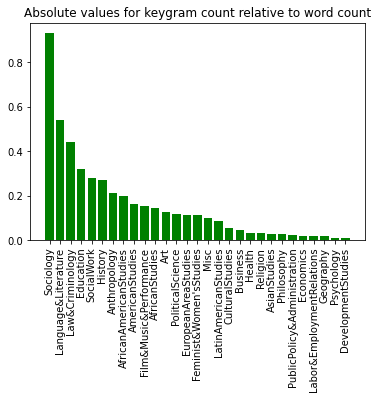

In [80]:
plt.bar(x=list(hstle.keys()), height=hstle.values(), color='g') # use sns.barplot instead
plt.xticks(rotation=90)
plt.title('Absolute values for keygram count relative to word count')
plt.savefig('Absolute values for keygram count relative to word count.jpg')
plt.show()

In [81]:
# averaging
for k,v in subject_count.items():
    hstle[k] /= v

In [82]:
hstle = {k: v for k, v in sorted(hstle.items(), key=lambda item: item[1], reverse=True)}
hstle

{'SocialWork': 0.009952289670356676,
 'Sociology': 0.006944168273646278,
 'Law&Criminology': 0.006313690753502878,
 'AmericanStudies': 0.004964999190378105,
 'Education': 0.004793010510607594,
 'Misc': 0.004003144416725477,
 'CulturalStudies': 0.003675308037155293,
 'AfricanStudies': 0.003398745139117708,
 'LatinAmericanStudies': 0.003362398822575325,
 'EuropeanAreaStudies': 0.0032656110918120314,
 'History': 0.003166500665568847,
 'AfricanAmericanStudies': 0.003081891155104209,
 "Feminist&Women'sStudies": 0.002753603806164737,
 'Anthropology': 0.00253577902010323,
 'Religion': 0.0024439250469959436,
 'Language&Literature': 0.0024114914186344027,
 'AsianStudies': 0.002340780887499952,
 'Business': 0.002297209187038246,
 'Health': 0.002288686662192002,
 'Psychology': 0.0022500830006193678,
 'Film&Music&Performance': 0.0022401508456412977,
 'Economics': 0.00209321919468378,
 'Philosophy': 0.0019787086684494356,
 'PublicPolicy&Administration': 0.0017840579290992033,
 'PoliticalScience': 0

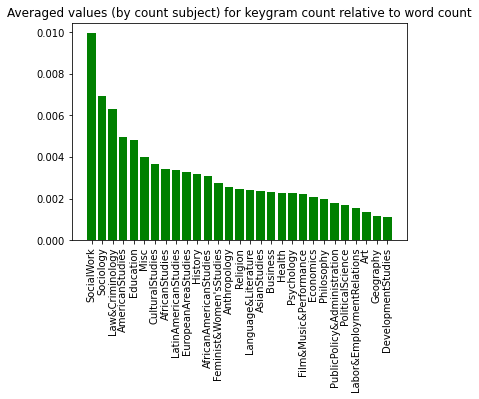

In [83]:
plt.bar(x=list(hstle.keys()), height=hstle.values(), color='g')
plt.xticks(rotation=90)
plt.title('Averaged values (by count subject) for keygram count relative to word count')
plt.savefig('Absolute values by count of subject for keygram count rel to word count.jpg')
plt.show()

### most frequent disciplines vs cities they mention
stacked dots histogram of top10 disciplines vs top5? top10? most freq mentioned cities https://stackoverflow.com/questions/50157795/pandas-stacked-dots-histogram

In [329]:
df.head(0)

,Unnamed: 0,filenames,city,country,continent,demonyms,date,title,subject,condensed_subject,keygram_count,word_count,shannon_idx_(country),avg_hdi,hdi_str,publisher


In [327]:
# sns.histplot(data=df, x='condensed_subject', kde=True, hue='avg_hdi')

### plot the disciplines (above a certain threshold of occurrences) that have seen the largest increase in mention over the preceding decade => perhaps these should be preselected for being above a threshold number of keygram hits?
scatterplot with number of occurrences on y-axis and dates on x-axis; disciplines (top 5?) should be in diff. colours

### plot the most freq total cities and their dates

In [ ]:
get_commonest(dftotal['total cities'], 15)

In [ ]:
c6_cities = get_commonest(dftotal['total cities'], 15)
citybins0 = {k:[] for k in c6_cities.keys()}
cities = df[['date', 'city']]
citybins0['date'] = []


switch = False
for idx,dts,cits in cities.itertuples():
    for k,v in eval(cits).items():
        if k in citybins0.keys():
            switch=True
            citybins0[k].append(v)
    if switch==True:
        citybins0['date'].append(dts)
        switch=False
    # check lengths of all vals, if unequal, then append 0 to all those keys whose vals are unequal
    max_val = 0
    for k,v in citybins0.items():
        if len(v) > max_val:
            max_val = len(v)

    for k,v in citybins0.items():
        if len(v) != max_val:
            citybins0[k].append(0)

# print(citybins)
# [print(len(v)) for k,v in citybins.items()]
#once we've binned the cities we can give each city column a colour in the scatterplot
citybins0 = pd.DataFrame(citybins0)

In [ ]:
plt.scatter(y=citybins0['newyorkcity'], x=citybins0['date'], color='red', s=4, label='NYC', alpha=0.3) # alpha is for transparency
plt.scatter(y=citybins0['chicago'], x=citybins0['date'], color='black', s=4, label='Chicago', alpha=0.3)
plt.scatter(y=citybins0['london'], x=citybins0['date'], color='brown', s=4, label='London', alpha=0.3)
plt.scatter(y=citybins0['losangeles'], x=citybins0['date'], color='blue', s=4, label='LA', alpha=0.3)
plt.scatter(y=citybins0['washington'], x=citybins0['date'], color='green', s=4, label='Wash.', alpha=0.3)
plt.scatter(y=citybins0['havana'], x=citybins0['date'], color='purple', s=4, label='Havana', alpha=0.3)
plt.title('Frequency of top 6 cities per date')
plt.legend()
plt.show()

In [ ]:
make_scatterplot(citybins0, 'date')

In [ ]:
# g = sns.jointplot(y='toronto',x='date',data=citybins0, kind='reg', scatter=False) # plot regression line independently of scatter
g = sns.JointGrid()
g.ax_joint.scatter(y='newyorkcity',x='date', c='purple', data=citybins0, alpha=0.5, s=5) # add scatter
g.ax_joint.scatter(y='havana', x='date', c='red', data=citybins0,alpha=0.5, s=5)

In [ ]:
nyc = citybins0[['newyorkcity', 'date']].loc[(citybins0['newyorkcity']<150)]
chic = citybins0[['chicago', 'date']].loc[(citybins0['chicago']<150)]
london = citybins0[['london', 'date']].loc[(citybins0['london']<150)]
la = citybins0[['losangeles', 'date']].loc[(citybins0['losangeles']<150)]
wash = citybins0[['washington', 'date']].loc[(citybins0['washington']<150)]
hav = citybins0[['havana','date']].loc[(citybins0['havana']<150)]

plt.scatter(y=nyc['newyorkcity'], x=nyc['date'], color='red', s=4, label='NYC', alpha=0.3) # alpha is for transparency
plt.scatter(y=chic['chicago'], x=chic['date'], color='black', s=4, label='Chicago', alpha=0.3)
plt.scatter(y=london['london'], x=london['date'], color='brown', s=4, label='London', alpha=0.3)
plt.scatter(y=la['losangeles'], x=la['date'], color='blue', s=4, label='LA', alpha=0.3)
plt.scatter(y=wash['washington'], x=wash['date'], color='green', s=4, label='Wash.', alpha=0.3)
plt.scatter(y=hav['havana'], x=hav['date'], color='purple', s=4, label='Havana', alpha=0.3)
plt.title('Frequency of top 6 cities vs frequency of hustling and cognates')
plt.legend()
plt.show()

### plot the most freq total cities against frequency of hustling

<ipython-input-115-d375a52a5221>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['keygram_count'] = _df['keygram_count']/df['word_count'] # relative to word count


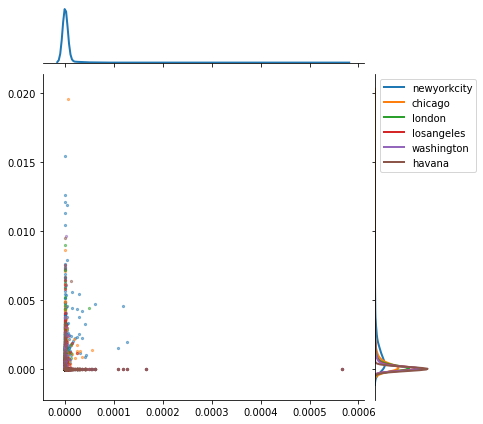

In [115]:
_df = df[['keygram_count', 'city']]
_df['keygram_count'] = _df['keygram_count']/df['word_count'] # relative to word count
citybins = evaluate_most_common(get_commonest(dftotal['total cities'], 6), _df[['keygram_count', 'city']])
citybins = pd.DataFrame(citybins)
for i in citybins.columns:
    if i != 'keygram':
        citybins[i] = citybins[i]/df['word_count']
citybins = citybins.to_dict(orient='list')
# display(citybins)
make_scatterplot(citybins, 'keygram_count', title=None, xlabel=None, ylabel=None)

the below is obsolete

In [86]:
c6_cities = get_commonest(dftotal['total cities'], 6)
citybins = {k:[] for k in c6_cities.keys()}
cities = df[['keygram_count', 'city']]
citybins['keygram_count'] = []


switch = False
for idx,freqs,cits in cities.itertuples():
    for k,v in eval(cits).items():
        if k in citybins.keys():
            switch=True
            citybins[k].append(v)
    if switch==True:
        citybins['keygram_count'].append(freqs)
        switch=False
    # check lengths of all vals, if unequal, then append 0 to all those keys whose vals are unequal
    max_val = 0
    for k,v in citybins.items():
        if len(v) > max_val:
            max_val = len(v)

    for k,v in citybins.items():
        if len(v) != max_val:
            citybins[k].append(0)

# print(citybins)
# [print(len(v)) for k,v in citybins.items()]
#once we've binned the cities we can give each city column a colour in the scatterplot
citybins = pd.DataFrame(citybins)

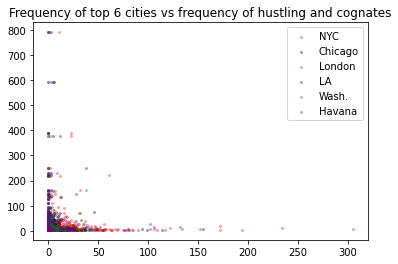

In [88]:
plt.scatter(x=citybins['newyorkcity'], y=citybins['keygram_count'], color='red', s=4, label='NYC', alpha=0.3) # alpha is for transparency
plt.scatter(x=citybins['chicago'], y=citybins['keygram_count'], color='black', s=4, label='Chicago', alpha=0.3)
plt.scatter(x=citybins['london'], y=citybins['keygram_count'], color='brown', s=4, label='London', alpha=0.3)
plt.scatter(x=citybins['losangeles'], y=citybins['keygram_count'], color='blue', s=4, label='LA', alpha=0.3)
plt.scatter(x=citybins['washington'], y=citybins['keygram_count'], color='green', s=4, label='Wash.', alpha=0.3)
plt.scatter(x=citybins['havana'], y=citybins['keygram_count'], color='purple', s=4, label='Havana', alpha=0.3)
plt.title('Frequency of top 6 cities vs frequency of hustling and cognates')
plt.legend()
plt.show()

In [109]:
nyc = citybins[['newyorkcity', 'keygram_count']].loc[(citybins['newyorkcity']>5) & (citybins['keygram_count']>5)]
chic = citybins[['chicago', 'keygram_count']].loc[(citybins['chicago']>5) & (citybins['keygram_count']>5)]
london = citybins[['london', 'keygram_count']].loc[(citybins['london']>5) & (citybins['keygram_count']>5)]
la = citybins[['losangeles', 'keygram_count']].loc[(citybins['losangeles']>5) & (citybins['keygram_count']>5)]
wash = citybins[['washington', 'keygram_count']].loc[(citybins['washington']>5) & (citybins['keygram_count']>5)]
hav = citybins[['havana', 'keygram_count']].loc[(citybins['havana']>5) & (citybins['keygram_count']>5)]


plt.scatter(x=nyc['newyorkcity'], y=nyc['keygram_count'], color='red', s=4, label='NYC', alpha=0.3) # alpha is for transparency
plt.scatter(x=chic['chicago'], y=chic['keygram_count'], color='black', s=4, label='Chicago', alpha=0.3)
plt.scatter(x=london['london'], y=london['keygram_count'], color='brown', s=4, label='London', alpha=0.3)
plt.scatter(x=la['losangeles'], y=la['keygram_count'], color='blue', s=4, label='LA', alpha=0.3)
plt.scatter(x=wash['washington'], y=wash['keygram_count'], color='green', s=4, label='Wash.', alpha=0.3)
plt.scatter(x=hav['havana'], y=hav['keygram_count'], color='purple', s=4, label='Havana', alpha=0.3)
plt.title('Frequency of top 6 cities vs frequency of hustling and cognates')
plt.legend()
plt.show()

TypeError: unhashable type: 'list'

### plot the most freq total demonyms against frequency of hustling

In [ ]:
res = get_commonest(dftotal['total demonyms'], 6)
dems = df[['keygram_count', 'demonyms']]

mc = evaluate_most_common(res, dems)
make_scatterplot(mc, 'keygram_count', title=None, xlabel='keygram_count', ylabel='demonyms')

### plot the most freq total demonyms and their dates

In [ ]:
res = get_commonest(dftotal['total demonyms'], 6)
dems = df[['date', 'demonyms']]

mc = evaluate_most_common(res, dems)
make_scatterplot(mc, 'date', title=None, xlabel='dates', ylabel='demonyms')

### plot the demonyms (above a certain threshold of occurrences) that have seen the largest increase in mention over the preceding decade => perhaps these should be preselected for being above a threshold number of keygram hits?

### Hustling Frequency vs Diversity (of denomyms and of cities) & relative diversity of demonyms & cities over time

In [205]:
# this was to get an overview over how many unique demonyms there are, how many are plurals etc
# total = set(ele for sublst in get_unique(df['demonyms']) for ele in sublst)

# total_edit = total.copy()
# suffixes = ['an', 'ian', 'ine', 'ite', 'er', 'eno', 'ish', 'ese', 'i', 'ic', 'iote', 'iard', 'tec', 'o', 'man', 'men', 'icana']
# exceptions = ['french', 'dutch', 'czech', 'jew']
# filtered = set()
# for ele in total:
#     #filtering out plurals
#     if ele.endswith('s'):
#         if ele[:-1] in total:
#             total_edit.remove(ele)
#     #heavier filter only allowing demonym-suffixes and some exceptions
#     if any(ele.endswith(x) for x in suffixes) or ele in exceptions:
#         filtered.add(ele)
        
# diff = total_edit - filtered
# print(len(total))
# print(len(total_edit))
# print(len(filtered))
# print(len(diff))
# print(diff)

In [78]:
def filter_demonyms(Series_to_eval, method='weak'):
    '''runs eval() on a pandas Series read from file and filters out plurals ('weak') and adds the vals of 
    plural to the singular; or filters ('strong') demonyms by suffixes or exception as well as adding plurals to vals of 
    singulars'''
    total = eval_series(Series_to_eval)
    return_lst = []
    if method == 'weak':
        for dct in total:
            filtered = {}
            for k,v in dct.items():
                # filtering out plurals and only adding the singular as key, but adding the vals of the plural to those of singular
                if k.endswith('s') and k[:-1] in dct.keys():
                    filtered[k[:-1]] = dct[k[:-1]] + dct[k]
                else:
                    filtered[k] = v
            return_lst.append(filtered)
            
    if method == 'strong':
        suffixes = ['an', 'ian', 'ine', 'ite', 'er', 'eno', 'ish', 'ese', 'i', 'ic', 'iote', 'iard', 'tec', 'o', 'man', 'men', 'icana']
        exceptions = ['french', 'dutch', 'czech', 'jew']
        for dct in total:
            _tmp = {}
            for k,v in dct.items():
                # filtering out plurals and only adding the singular as key, but adding the vals of the plural to those of singular
                if k.endswith('s') and k[:-1] in dct.keys():
                    _tmp[k[:-1]] = dct[k[:-1]] + dct[k]
                else:
                    _tmp[k] = v
            filtered = {}
            for k,v in _tmp.items():
                if any(k.endswith(x) for x in suffixes) or k in exceptions:
                    filtered[k] = v
            return_lst.append(filtered)
                
    return return_lst

In [79]:
def shannon_idx(Series_to_eval):
    '''see: https://en.wikipedia.org/wiki/Diversity_index'''
    sidx = []
    for idx, col in Series_to_eval.iteritems():
        sums = 0
        N = sum(v for v in eval(col).values())
        for k,v in eval(col).items():
            sums += v/N * np.log(v/N)
        sidx.append(np.abs(sums))
    return sidx


def shannon_idx_dct(dct):
    '''see: https://en.wikipedia.org/wiki/Diversity_index'''
    sums = 0
    N = sum(v for v in dct.values())
    for k,v in dct.items():
        sums += v/N * np.log(v/N)
    return np.abs(sums)

#unit tests
# shannon_idx_dct({'a': 98, 'b': 1, 'c': 1})#, 'd':30, 'e':70, 'f': 10})

#### Hustling Frequency vs Diversity (of denomyms, of cities, and of countries)

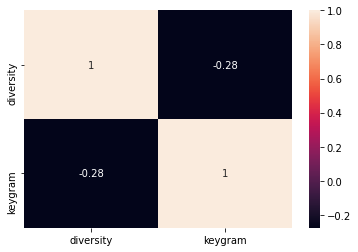

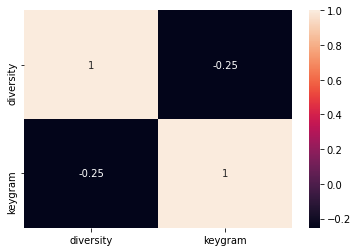

In [80]:
#demonyms filtered 'weakly'
dms_filtered_weak = filter_demonyms(df['demonyms'])
dms_diversity_weak = [shannon_idx_dct(dct) for dct in dms_filtered_weak]
dms_diversity_weak = pd.DataFrame(dms_diversity_weak, columns=['diversity'])
dms_diversity_weak['keygram'] = df['keygram_count']/df['word_count']

dms_weak_cor_mtx = dms_diversity_weak.corr('pearson')
plot = sns.heatmap(dms_weak_cor_mtx, annot=True)
# plot.figure.savefig('./JSTOR data/covariance.jpg')
plt.show()


dms_filtered_strong = filter_demonyms(df['demonyms'], 'strong')
dms_diversity_strong = [shannon_idx_dct(dct) for dct in dms_filtered_strong]
dms_diversity_strong = pd.DataFrame(dms_diversity_strong, columns=['diversity'])
dms_diversity_strong['keygram'] = df['keygram_count']/df['word_count']
# print(max(dms_diversity_weak))
# print(max(dms_diversity_strong))

dms_strong_cor_mtx = dms_diversity_strong.corr('pearson')
plot = sns.heatmap(dms_strong_cor_mtx, annot=True)
# plot.figure.savefig('./JSTOR data/covariance.jpg')
plt.show()

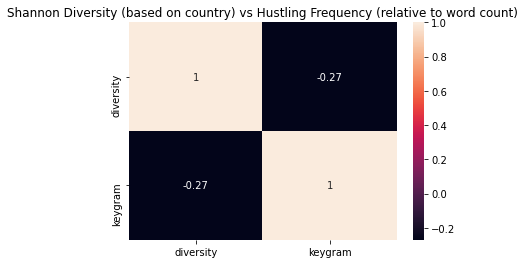

In [85]:
# country diversity correlation with hustling frequency
country_diversity = shannon_idx(df['country'])
country_diversity = pd.DataFrame(country_diversity, columns=['diversity'])
country_diversity['keygram'] = df['keygram_count']/df['word_count']
diversity_cor_mtx = country_diversity.corr('pearson')
plot = sns.heatmap(diversity_cor_mtx, annot=True)
plt.title('Shannon Diversity (based on country) vs Hustling Frequency (relative to word count)')
plt.savefig('./JSTOR data/graphs/countrydiversity_keygram_rel_wc_pearson.jpg')
plt.show()

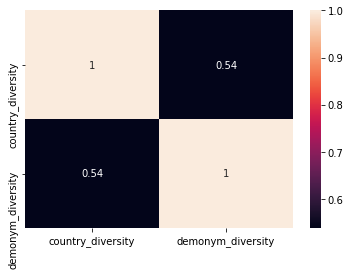

In [19]:
_mutual_diversity = country_diversity['diversity']
mutual_diversity = pd.DataFrame()
mutual_diversity['country_diversity'] = _mutual_diversity
mutual_diversity['demonym_diversity'] = dms_diversity_weak['diversity']

mutual_diversity = mutual_diversity.corr()
plot = sns.heatmap(mutual_diversity, annot=True)
# plot.figure.savefig('./JSTOR data/covariance.jpg')
plt.show()

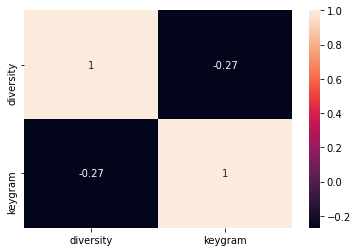

In [82]:
# city diversity correlation with hustling frequency
city_diversity = shannon_idx(df['city'])
city_diversity = pd.DataFrame(country_diversity, columns=['diversity'])
city_diversity['keygram'] = df['keygram_count']/df['word_count']
diversity_cor_mtx = city_diversity.corr('pearson')
plot = sns.heatmap(diversity_cor_mtx, annot=True)
plt.show()

In [77]:
# df['shannon_idx_(country)'] = shannon_idx(df['country'])
# df.to_excel('./JSTOR data/topgram_geo2.xlsx')

#### measure relative diversity of demonyms & cities over time

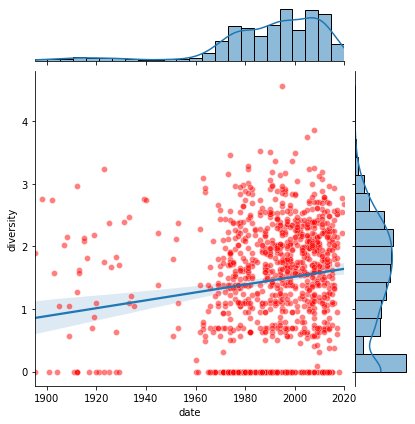

In [48]:
#demonyms filtered 'weakly'
dms_filtered_weak = filter_demonyms(df['demonyms'])
dms_diversity_weak = [shannon_idx_dct(dct) for dct in dms_filtered_weak]
dms_diversity_weak = pd.DataFrame(dms_diversity_weak, columns=['diversity'])
dms_diversity_weak['date'] = df['date']
g = sns.jointplot(x='date', y='diversity', kind='reg', data=dms_diversity_weak, scatter=False)
g.plot_joint(sns.scatterplot, color="r", alpha=0.5)
plt.show()

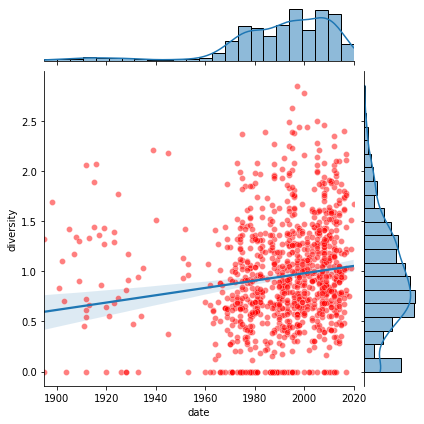

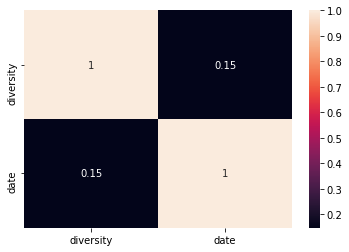

In [75]:
country_diversity = shannon_idx(df['country'])
country_diversity = pd.DataFrame(country_diversity, columns=['diversity'])
country_diversity['date'] = df['date']

g = sns.jointplot(x='date', y='diversity', kind='reg', data=country_diversity, scatter=False)
g.plot_joint(sns.scatterplot, color="r", alpha=0.5)
plt.savefig('./JSTOR data/totaldates_diversity_scatter.jpg')
plt.show()

c_d_corr_mtc = country_diversity.corr('pearson')
g2 = sns.heatmap(c_d_corr_mtc, annot=True)
plt.savefig('./JSTOR data/totaldates_diversity_pearson.jpg')
plt.show()

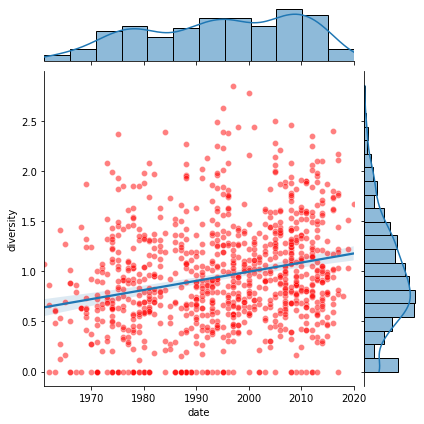

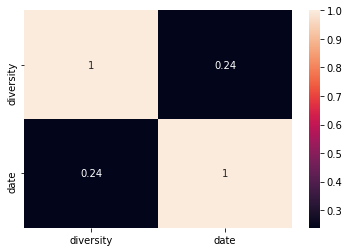

In [74]:
## the same as above only with data from 1960s to present
country_diversity2 = country_diversity.loc[country_diversity['date']>1960]

g = sns.jointplot(x='date', y='diversity', kind='reg', data=country_diversity2, scatter=False)
g.plot_joint(sns.scatterplot, color="r", alpha=0.5)
plt.savefig('./JSTOR data/1960-2020dates_diversity_scatter.jpg')
plt.show()

c_d_corr_mtc = country_diversity2.corr('pearson')
g2 = sns.heatmap(c_d_corr_mtc, annot=True)
plt.savefig('./JSTOR data/1960-2020dates_diversity_pearson.jpg')
plt.show()

### plotting total geodata (taken from the counts of continents) vs hustling frequency

In [ ]:
geosums = []
keycount = []
for ix, cnt, kcount in df[['continent', 'keygram_count']].itertuples():
    geosums.append(sum([v for k,v in eval(cnt).items()]))
    keycount.append(kcount)
    
plt.scatter(x=geosums, y=keycount, s=5, alpha=0.5)
plt.show()

In [ ]:
select = df[(df['keygram_count']>14) & (df['word_count']>1000)]
len(select)

In [ ]:
datebins = [1890,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020]
df['decade'] = pd.cut(df['date'], [1890,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020])
display(df)

        

### HDI vs diversity

<AxesSubplot:>

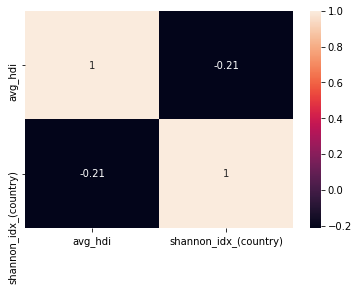

In [8]:
_dfcor = df[['avg_hdi', 'shannon_idx_(country)']]
mtx = _dfcor.astype(float).corr()
sns.heatmap(mtx, annot=True)

<ipython-input-20-8633b046bf0c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _dfcor['hdi_str'] = df['hdi_str']


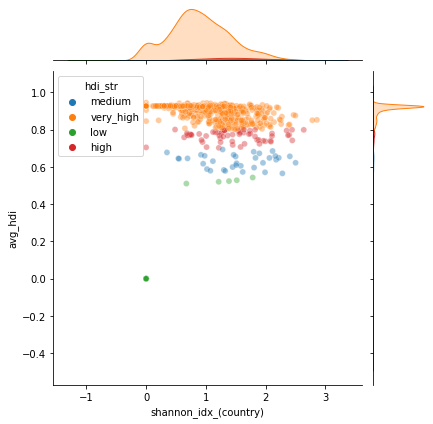

In [20]:
_dfcor['hdi_str'] = df['hdi_str']
g = sns.jointplot(data=_dfcor, y='avg_hdi', x='shannon_idx_(country)', hue='hdi_str', alpha=0.4)

<AxesSubplot:>

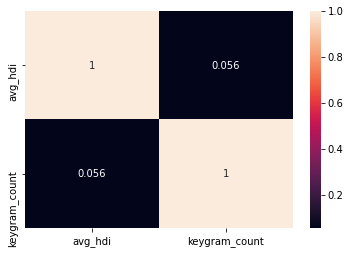

In [219]:
_dfcor = df[['avg_hdi', 'keygram_count']]
mtx = _dfcor.astype(float).corr()
sns.heatmap(mtx, annot=True)

In [192]:
df.head(0)

,Unnamed: 0,filenames,city,country,continent,demonyms,date,title,subject,keygram_count,word_count,shannon_idx_(country),avg_hdi,hdi_str


### make covariance and correlation matrices of cities and demonyms

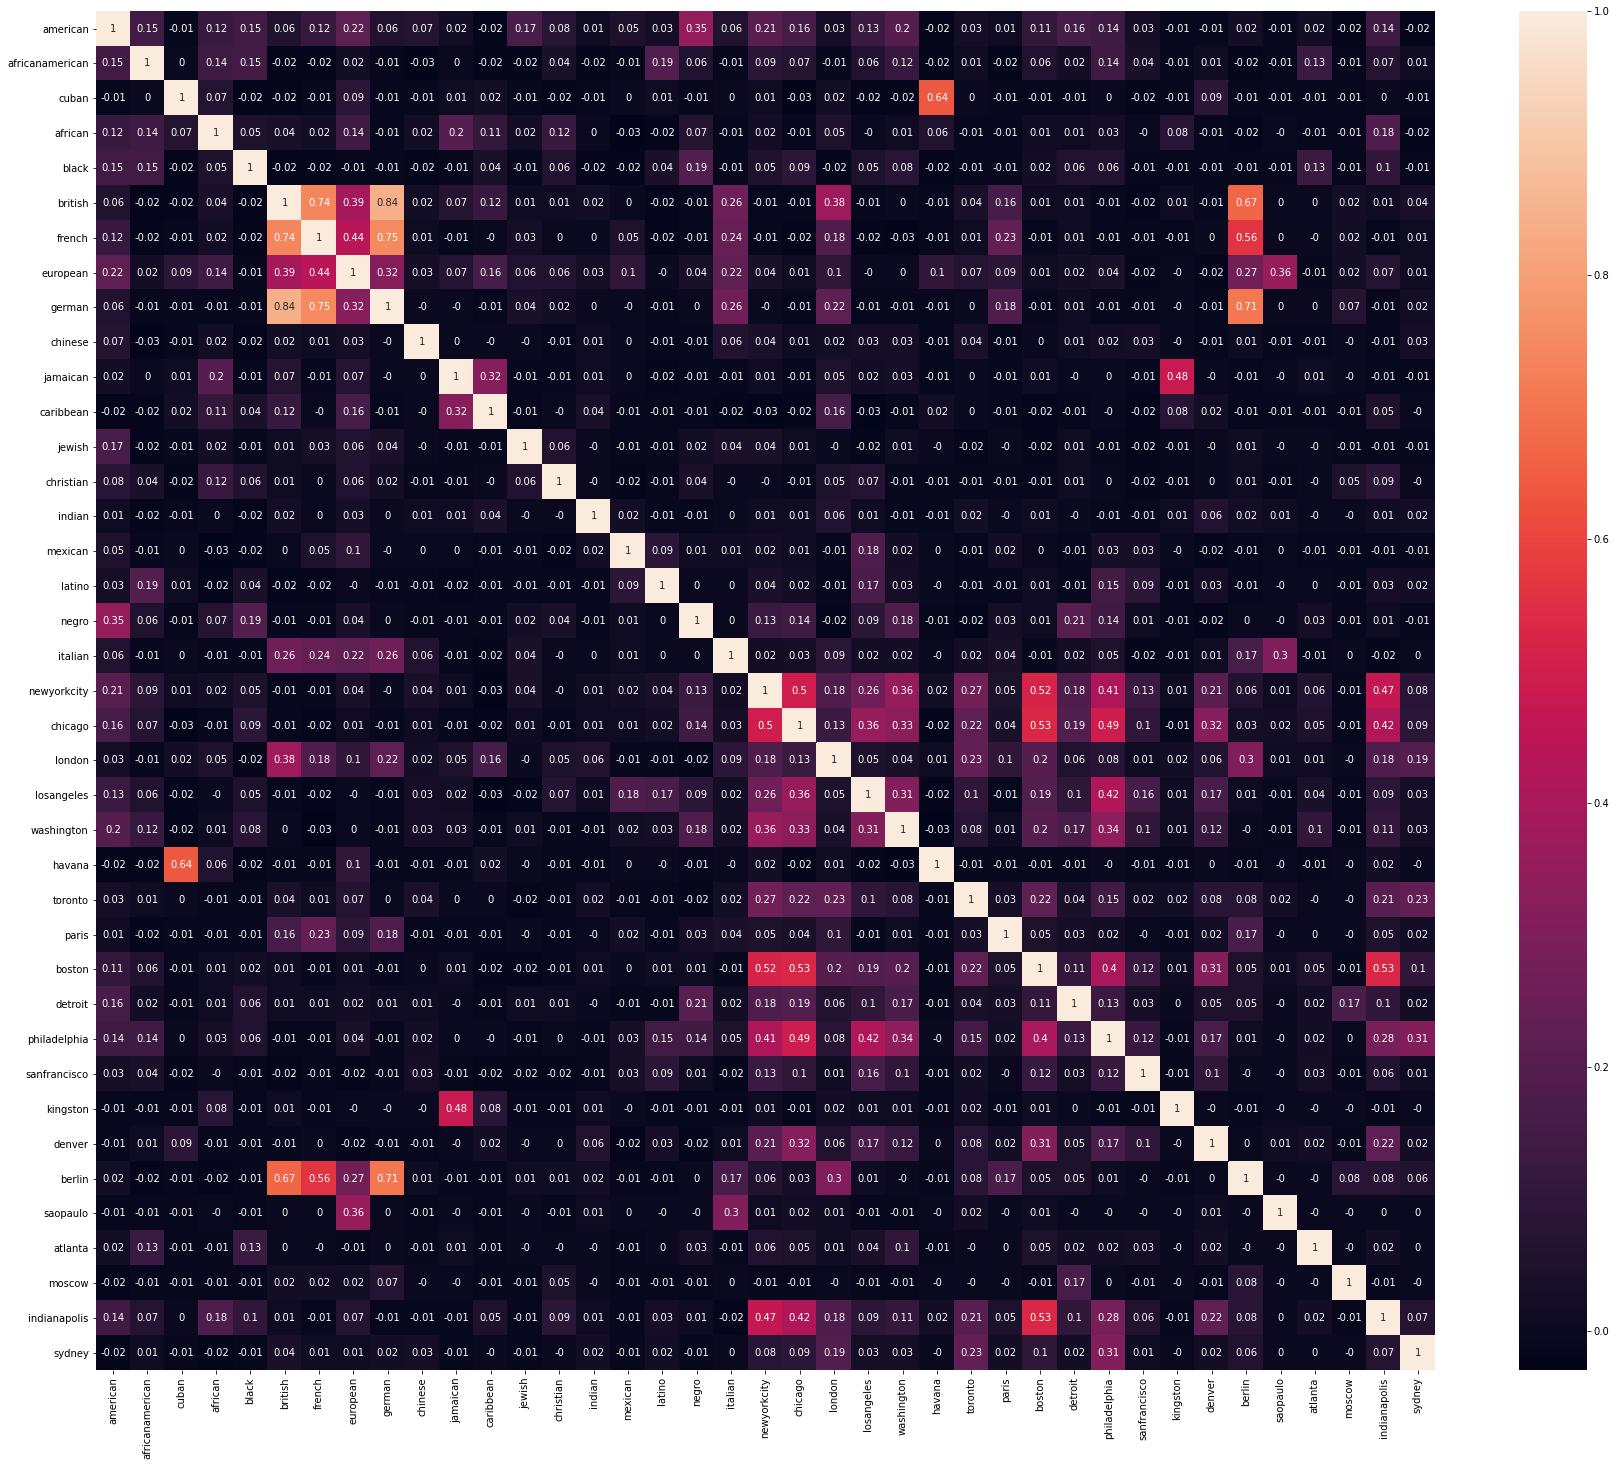

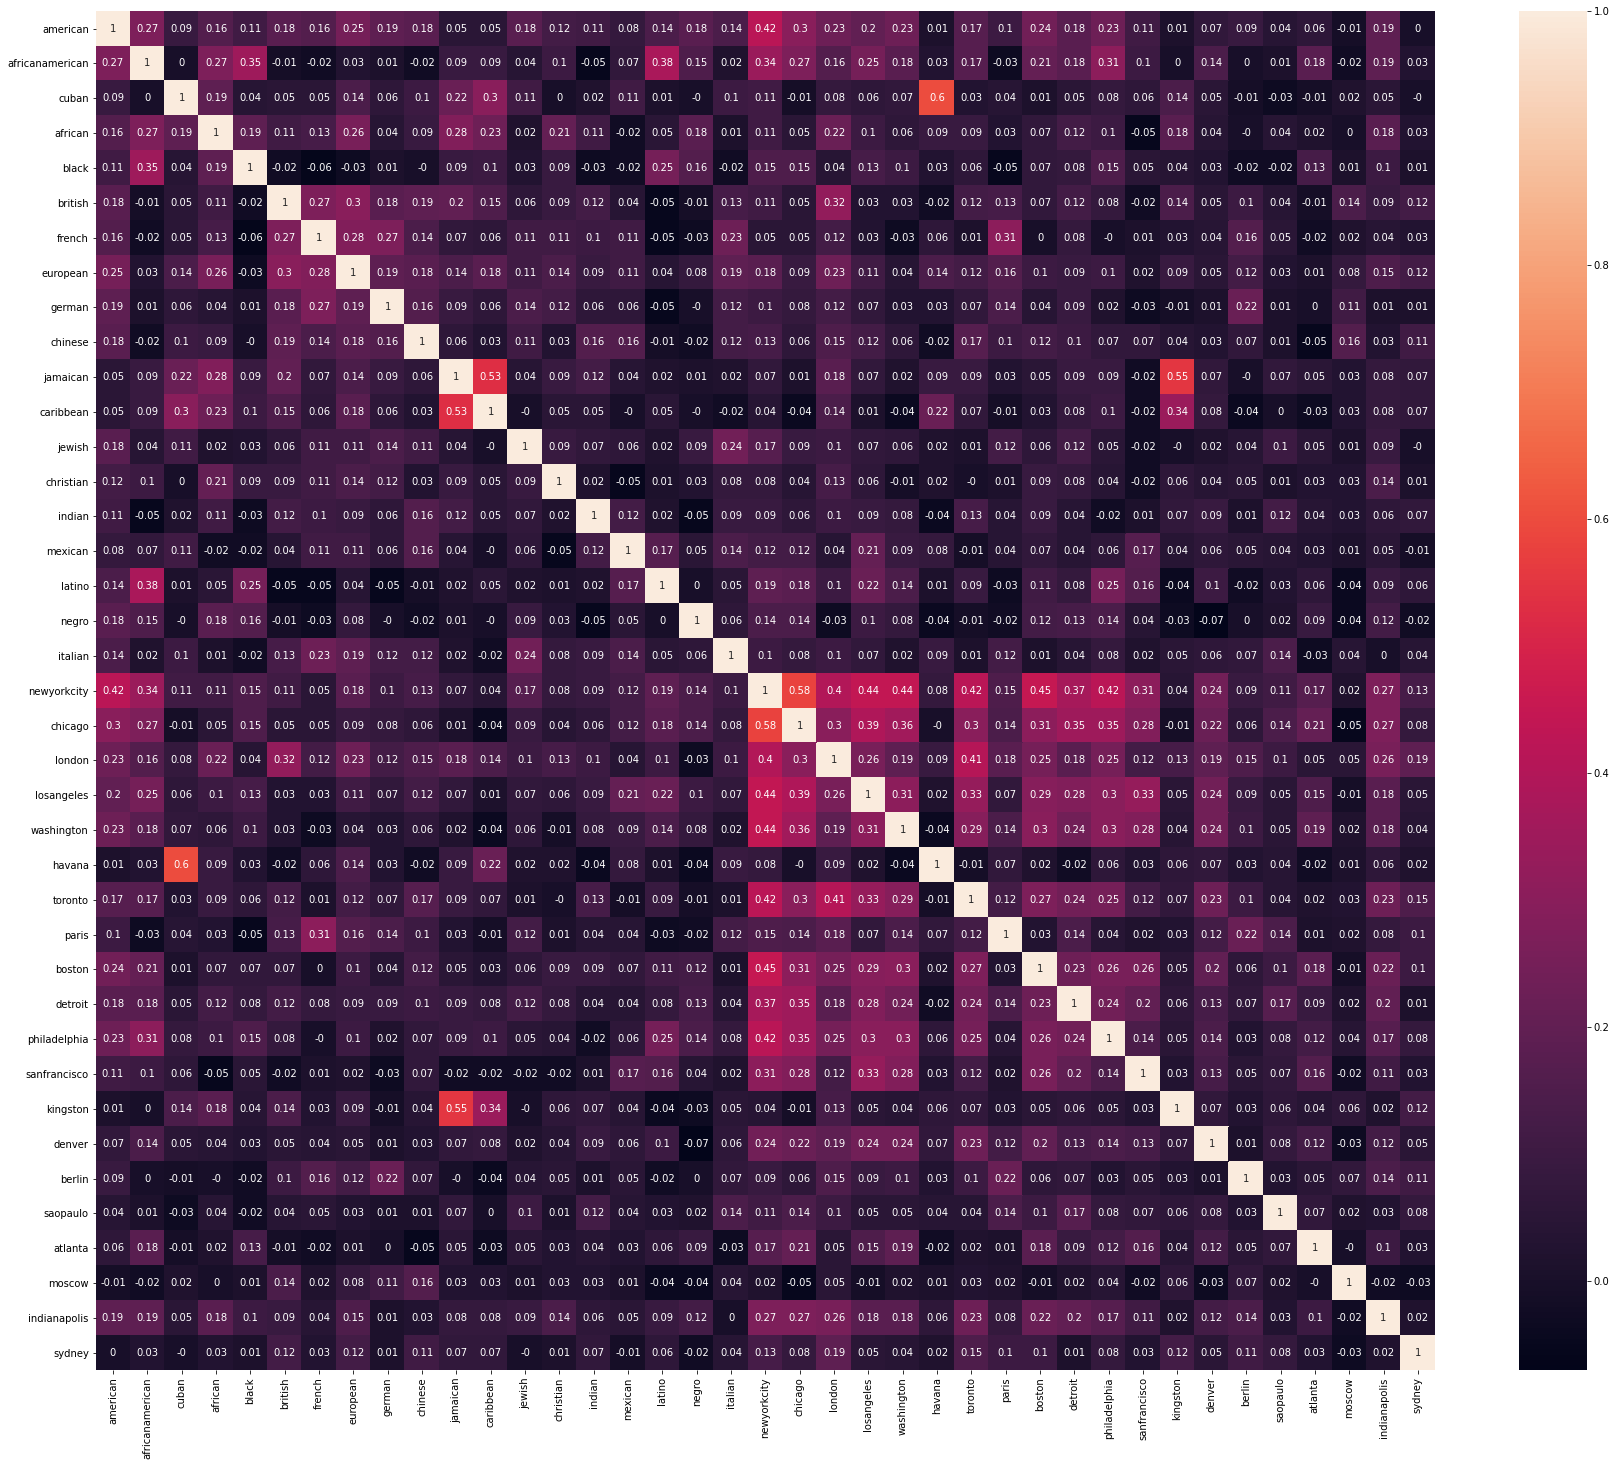

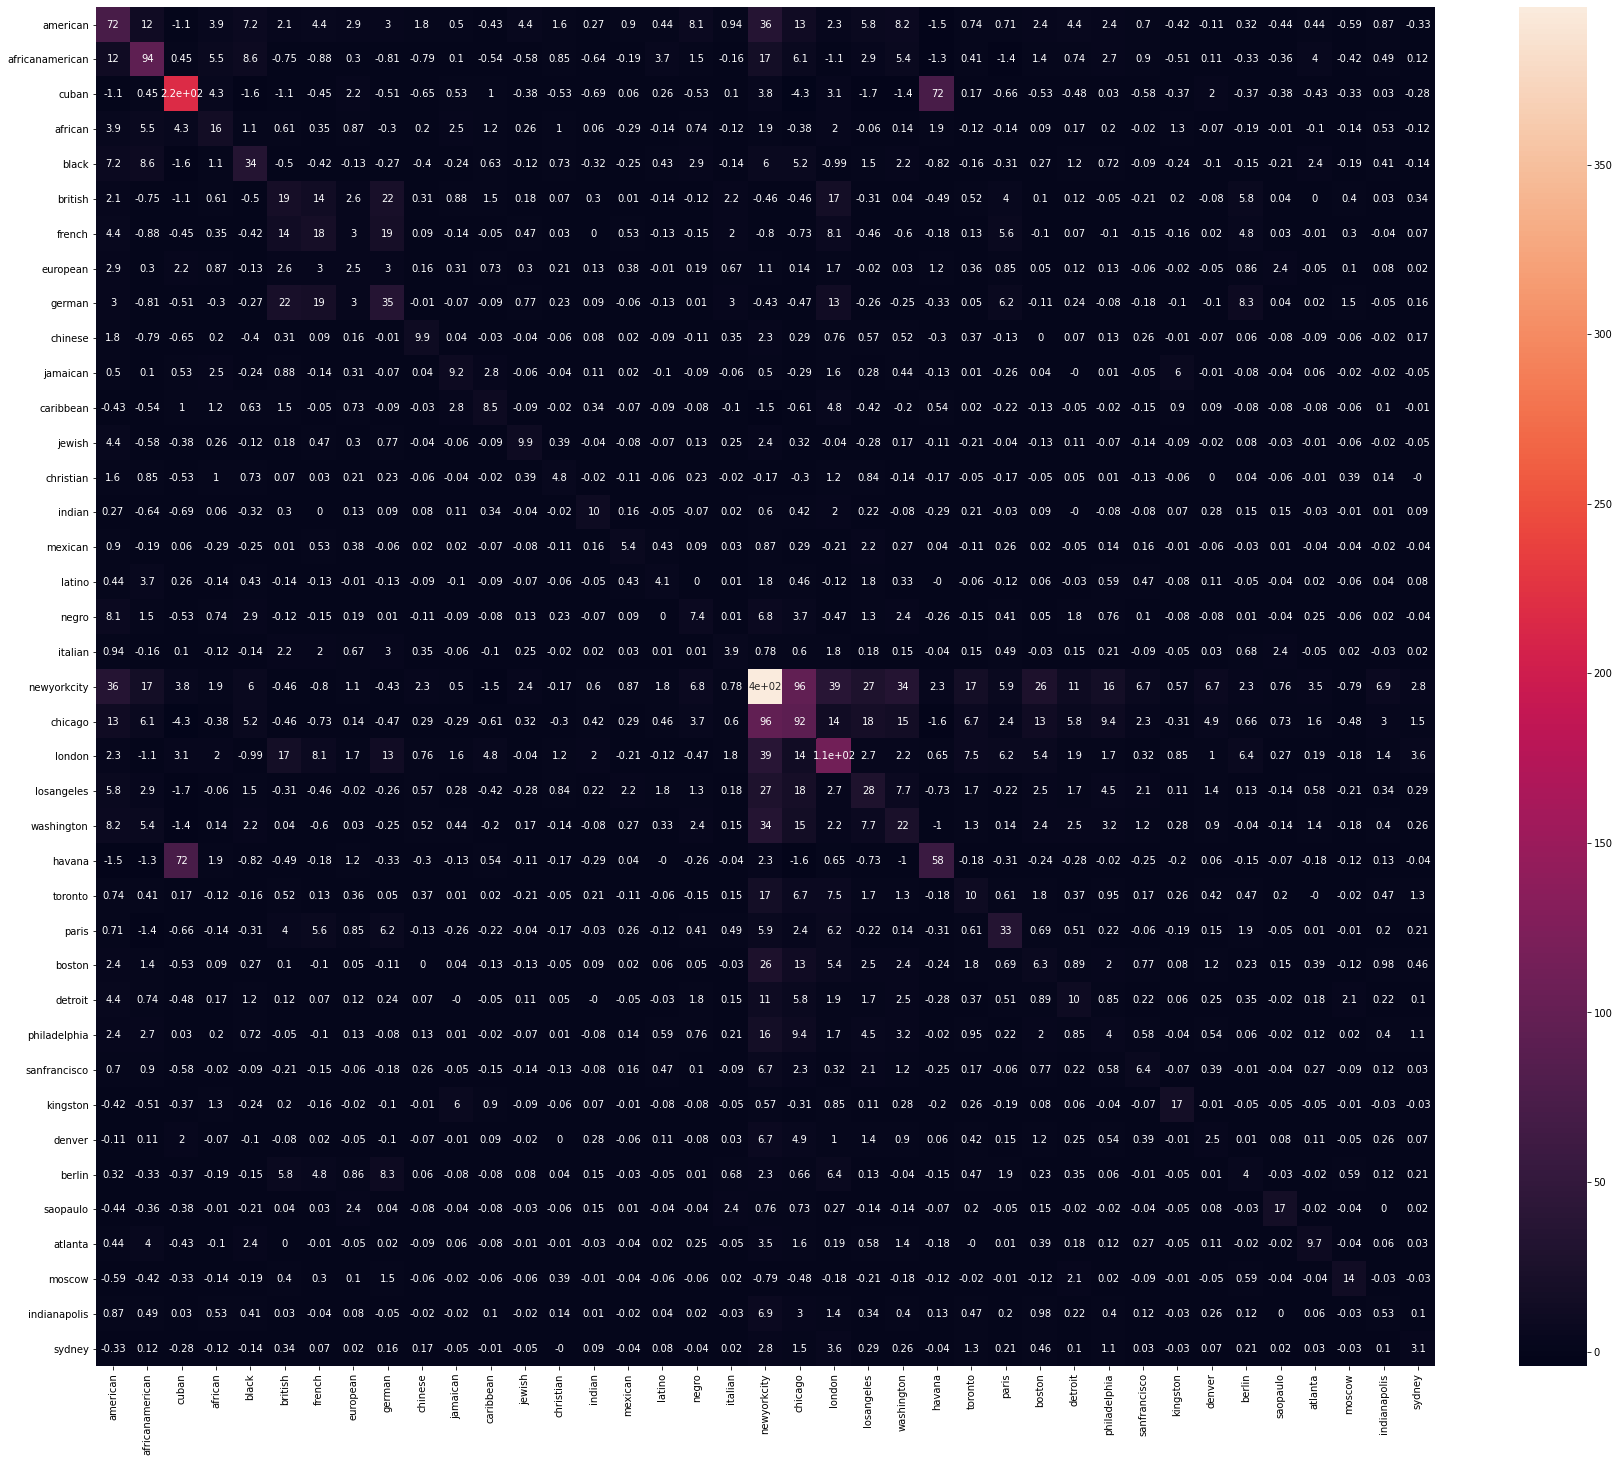

In [31]:
dres = get_commonest(dftotal['total demonyms'], 22)
cres = get_commonest(dftotal['total cities'], 20)

d_df = df[['date', 'demonyms']]
md = evaluate_most_common(dres,d_df)
# [print(len(v)) for k,v in md.items()]
md = {key: val for key, val in md.items() if key != 'date'} # a bit of an ugly fix, but better than writing a separate function
df1 = pd.DataFrame(md)
##adding pandas Series of plurals to pandas Series of singulars (e.g. American = Americans + American)
for col in df1.columns:
    if col.endswith('s'):
        df1[col[:-1]] = df1[col[:-1]] + df1[col]
        df1.drop(col, axis=1, inplace=True)

c_df = df[['date', 'city']]
mc = evaluate_most_common(cres,c_df)
# [print(k,v) for k,v in mc.items()]
mc = {key: val for key, val in mc.items() if key != 'date'} # a bit of an ugly fix, but better than writing a separate function
df2 = pd.DataFrame(mc)

merged = pd.concat([df1, df2], axis=1)
corr_mtx_p = merged.corr(method='pearson').round(2)#.replace(1, 0)  # replacing perfect correlations (because they don't actually exist) and rounding to nearest 2 decimals
# display(corr_mtx)

plt.subplots(figsize=(30,25)) # to make it bigger, has to be called before the actual plotting function
plot = sns.heatmap(corr_mtx_p, annot=True)
# plot.figure.savefig('./JSTOR data/pearson_correlation.jpg')
plt.show()

corr_mtx_sp = merged.corr(method='spearman').round(2)#.replace(1, 0)  # replacing perfect correlations (because they don't actually exist) and rounding to nearest 2 decimals
# display(corr_mtx)

plt.subplots(figsize=(30,25)) # to make it bigger, has to be called before the actual plotting function
plot = sns.heatmap(corr_mtx_sp, annot=True)
# plot.figure.savefig('./JSTOR data/spearman_correlation.jpg')
plt.show()


cov_mtx_sp = merged.cov().round(2)#.replace(1, 0)  # replacing perfect correlations (because they don't actually exist) and rounding to nearest 2 decimals
# display(corr_mtx)

plt.subplots(figsize=(30,25)) # to make it bigger, has to be called before the actual plotting function
plot = sns.heatmap(cov_mtx_sp, annot=True)
# plot.figure.savefig('./JSTOR data/covariance.jpg')
plt.show()

# collocation & neural net word embeddings

## getting the collocation data

In [13]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english') + ['however','around', 'pp','amp','although','rather','might','im', 'must','dont','tion', 'still', 'ing','also', 'would', 'could', 'ain\'t', 'even', 'us', 'one', 'two', 'three', 'may']
from nltk.stem import PorterStemmer

df = pd.read_excel('./JSTOR data/topgram_geo2.xlsx', engine='openpyxl')
dffiles = df['filenames'].values

In [14]:
def PunctuationRemover(wordstring, return_list=False):
    assert type(wordstring) == str
    a = wordstring.replace('-', '')
    translator = str.maketrans('', '', string.punctuation)
    g = a.translate(translator)
    h = re.sub('(«|»)', '', g)
    if return_list == True:
        h = h.split()
    return h

In [2]:
def get_filename(file):
    lst = str(file).replace('.txt', '').split('\\')
    return lst[-1]

def tokenise(wordstring, stem=False):
    str1 = PunctuationRemover(wordstring)
    if stem:
        porter = PorterStemmer()
        lst1 = [porter.stem(w) for w in str1.lower().split() if w not in stop_words and w.isalpha() and len(w)>1]
    else:
        lst1 = [w for w in str1.lower().split() if w not in stop_words and w.isalpha() and len(w)>1]
    return lst1

In [16]:
def KeyGram(keyword, tokenlist, n_length=10):
    '''n_length is applied to either side, so will get n_length to the left and right of keyword'''
    cache_lst = []
    count_backward = 0
    switch = False
    for index, word in enumerate(tokenlist):
        cache_string = ''
        if count_backward == n_length and switch == True:
            cache_string += str(tokenlist[index - n_length:index])
            switch = False
            count_backward = 0
        elif switch == True and count_backward < n_length:
            count_backward += 1
        elif word.lower() == keyword.lower():
            # in case string shorter than n_length on either end of the keyword
            if n_length > int(int(len(tokenlist[:index]) - 2)) and n_length > int(int(len(tokenlist[index:]) - 2)):
                cache_string += str(tokenlist)
            # in case string shorter than n_length before the keyword
            elif n_length > int(int(len(tokenlist[:index]) - 2)):
                cache_string += str(tokenlist[:index]) + ' ' + str([keyword]) + ' '
                switch = True
            # in case string is longer than n_length on either side of keyword
            elif n_length <= int(int(len(tokenlist[:index]) - 2)) and n_length <= int(int(len(tokenlist[index:]) - 2)):
                cache_string += str(tokenlist[index - n_length:index]) + ' ' + str([keyword]) + ' '
                switch = True
            # in case string shorter than n_length after the keyword
            elif n_length > int(int(len(tokenlist[index:]) - 2)):
                cache_string += str(tokenlist[index+1:])
        cache_string = cache_string.replace('[', '').replace(']', '').replace('\'', '').replace(',', '')
        if cache_string:
            cache_lst.append(cache_string)
    return cache_lst

getting the word frequencies

In [17]:
doc_counter = []
count = 0
for file in pl.Path('./JSTOR/ocr/').iterdir():
    if file.is_file():
        _name = get_filename(file)
        if _name in dffiles:
            count+=1
            with open(file, encoding='utf8', errors='ignore') as file_open:
                f = file_open.read()
                t = tokenise(f)
                c = Counter(t)
                doc_counter.append(c)
                
print(count)

1000


In [18]:
total_word_freq = sum(doc_counter, Counter())
print('there are', len(total_word_freq), 'unique words in this corpus') # there are 189,061 unique words in this corpus
print('there are a total of', sum(total_word_freq.values()), 'number of words in this corpus') # 4,615,640 

there are 189039 unique words in this corpus
there are a total of 4615640 number of words in this corpus


In [19]:
most_freq_total = total_word_freq.most_common(100)
print(most_freq_total)
### dropping the less frequent words
corrected_total_word_freq = Counter(el for el in total_word_freq.elements() if total_word_freq[el] > 3)
print(len(corrected_total_word_freq))

[('new', 17517), ('black', 16191), ('social', 13682), ('work', 12267), ('see', 12186), ('like', 11185), ('people', 10234), ('time', 10223), ('men', 10077), ('women', 9802), ('many', 9216), ('american', 8959), ('life', 8820), ('first', 8101), ('york', 7968), ('use', 7607), ('drug', 7049), ('man', 7003), ('white', 6904), ('way', 6887), ('public', 6567), ('university', 6511), ('well', 6397), ('sex', 6354), ('street', 6320), ('years', 6212), ('much', 6134), ('know', 6084), ('get', 6082), ('press', 6070), ('young', 5913), ('world', 5908), ('said', 5821), ('city', 5820), ('among', 5799), ('state', 5734), ('research', 5708), ('make', 5687), ('often', 5489), ('made', 5473), ('sexual', 5436), ('culture', 5419), ('political', 5328), ('de', 5266), ('school', 5247), ('money', 5012), ('crime', 4963), ('part', 4961), ('study', 4939), ('within', 4837), ('society', 4752), ('back', 4735), ('another', 4664), ('urban', 4636), ('good', 4484), ('group', 4480), ('family', 4446), ('economic', 4445), ('male',

 getting the collocative freqs per doc for hustling and cognates

In [ ]:
doc_colloc_counter = []
keywords = ['hustle', 'hustled', 'hustler', 'hustlers', 'hustles','hustling']

count = 0
for file in pl.Path('./JSTOR/ocr/').iterdir():
    if file.is_file():
        _name = get_filename(file)
        if _name in dffiles:
            count+=1
#             print(count)
            with open(file, encoding='utf8', errors='ignore') as file_open:
                collocs = []
                f = file_open.read()
                t = tokenise(f)
                for key in keywords:
                    k = KeyGram(key, t, n_length=10)
                    collocs.append(k)
                collocs = ''.join(str(collocs)).replace('[', '').replace(']', '').replace('\'', '').replace(',', '')
                c = Counter(collocs.split())
                doc_colloc_counter.append(c)
print(count)

In [ ]:
keygram_total_colloc = sum(doc_colloc_counter, Counter())
most_common_contexts = keygram_total_colloc.most_common(100)
print('there are:',len(keygram_total_colloc), 'unique context words to the keyword') # outputs: 19061
print('there are a total of', sum(keygram_total_colloc.values()), 'words in the keygram collocation corpus') # 109,282
print(most_common_contexts)

Getting various collocation measures for the top 100 most frequent words in the total corpus (of top 1k docs)

In [ ]:
N = sum(total_word_freq.values())

word = []
mi = []
t = []
cor_t = []
for k,v in most_common_contexts:
    word.append(k)
    WC = keygram_total_colloc.get(k, 0)
    C = total_word_freq.get(k,0)
    W = total_word_freq.get(k,0)
    mi.append(Collocation_Metrics(N, C, W, WC).MI())
    t.append(Collocation_Metrics(N, C, W, WC).t_score())
    cor_t.append(Collocation_Metrics(N, C, W, WC).corrected_t_score(20))

In [ ]:
# _frame = pd.DataFrame(list(zip(word,mi,t,cor_t)), columns = ['word','MI', 't-score', 'corrected t-score'])
# _frame.to_excel('./JSTOR data/collocation metrics.xlsx')

## Collocation analysis measures

In [ ]:
class Collocation_Metrics():
    """for these formulas, see Brezina: statistics in corpus linguistics, p. 72. 
    t-score corrected by window size seems to be the least extreme in 
    susceptibility to frequency and exclusivity (see ibid., p. 74)"""
    def __init__(self,N, C, W, WC):
        self.N = N # total words
        self.C = C # collocate frequency in total corpus
        self.W = W # frequency of target token/word
        self.WC = WC # frequency of co-occurrence of word and collocate
        
    def _expected(self):
        return (self.W*self.C)/self.N
    
    def _corrected_expected(self, window_size):
        return (self.W*self.C*window_size)/self.N
    
    def MI(self):
        return np.log2(self.WC/self._expected())
    
    def MI2(self):
        return np.log2(self.WC**2/self._expected())
    
    def MI3(self):
        return np.log2(self.WC**3/self._expected())
    
    def z_score(self):
        return (self.C - self._expected())/np.sqrt(self._expected())
    
    def t_score(self):
        return (self.WC - self._expected())/np.sqrt(self.WC)
    
    def corrected_t_score(self, window_size):
        return (self.WC - self._corrected_expected(window_size))/np.sqrt(self.WC)

In [ ]:
## unit tests for some of the score
N = 12422985
W = 875
C = 15
WC = 4

mut_info = round(Collocation_Metrics(N, C, W, WC).MI(),2)
assert mut_info == 11.89
tscore = round(Collocation_Metrics(N, C, W, WC).t_score(),1)
assert tscore == 2.00

## Neural Net embeddings:
1. embeddings: https://arxiv.org/abs/1301.3781
2. temporal alignment https://github.com/valedica/twec#:~:text=Temporal%20word%20embeddings%20have%20been,during%20a%20specific%20time%20interval
https://ojs.aaai.org//index.php/AAAI/article/view/4594


### sorting keygrams by time bins for use by Word2Vec

In [92]:
b = df1k.bins[df1k.filenames == 'journal-article-10.2307_1600430'].to_numpy()
b = re.sub('[\[\]\(\) ]', '',str(b[0]).replace(',','-'))
print(b)
# df1k.filenames.loc['journal-article-10.2307_1600430']

1990-2000


In [89]:

d = {re.sub('[\[\]\(\) ]', '',str(k).replace(',','-')):[] for k in df1k.bins.unique()}#[uniques[i] for i in range(len(uniques))]}
d.keys()

dict_keys(['2010-2020', '2000-2010', '1990-2000', '1920-1930', '1960-1970', '1970-1980', '1980-1990', '1910-1920', '1930-1940', '1950-1960', '1900-1910', '1890-1900', '1940-1950'])

Creating time-sliced txt documents from all the keygrams extracted earlier (see step 3 above), so that all the keygrams from texts published in, say, the timeframe 1990-2000 are in one txt file. this will then be used to train time-specific word embeddings. there is also a total txt with all the keygrams (irrespective of timeframe), which will be used as a 'compass' to align the vector-spaces for the time-slices (see article above).

In [105]:
df1k = pd.read_excel('./JSTOR data/topgram_geo2.xlsx', engine='openpyxl')
bins = [1880,1890,1900, 1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020]
df1k['bins'] = pd.cut(df1k['date'], bins)


tfile = open('./JSTOR data/time_order_keygrams/total.txt', 'a', encoding='utf8')
count = 0
total = ''
timedict = {re.sub('[\[\]\(\) ]', '',str(k).replace(',','-')):[] for k in df1k.bins.unique()} # the use of regex here is only to convert the array intervals into simple string, e.g. '1990-2000'

for file in pl.Path('./JSTOR data/keygrams').iterdir():
    if file.is_file():
        _name = get_filename(file)
        if _name in df1k.filenames.values:
            count+=1

            with open(file, encoding='utf8', errors='ignore') as file_open:

                f = file_open.read()
                t = tokenise(f)
                t = re.sub('[\(\[\]/\)\'\,\"]','',''.join(str(t)))
                tfile.write(t)
                
                # getting the bin for the filename, converting it to a readable string, so that we can use it for the dictionary
                b = df1k.bins[df1k.filenames == _name].to_numpy()
                b = re.sub('[\[\]\(\) ]', '',str(b[0]).replace(',','-'))
                
                # looking up b as a key in the timedict and adding t as the associated value 
                timedict[b].append(t)
                
#                 if count == 10:
#                     break
tfile.close()
print(count)
# print(timedict)

for k,v in timedict.items():
    with open('./JSTOR data/time_order_keygrams/' + str(k)+'.txt', 'w+', encoding='utf8') as writer:
        writer.write(re.sub('[\(\[\]/\)\'\,\"]','',''.join(str(v)))) # regex here used to make the dict value into a clean string (it is originally a list)

1000


### visualising word embeddings

In [8]:
from gensim.models.word2vec import Word2Vec

c:\users\jackewiebohne\appdata\local\programs\python\python38\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [9]:
def get_filename(file):
    lst = str(file).replace('.txt', '').split('\\')
    return lst[-1]

#### pre-processing

In [10]:
directory = r'C:\Users\jackewiebohne\Documents\python tests\DTA\model'

model = Word2Vec.load(r'C:\Users\jackewiebohne\Documents\python tests\DTA\model\compass.model')

# model.wv.save_word2vec_format('./JSTOR data/totalvec.txt', binary=False) # to save the file in a readable way
# print(model.wv['hustling']) # accessing word vectors

In [24]:
# keys = ['hustled', 'hustle', 'hustles', 'hustler', 'hustlers', 'hustling']

# sims = {}
# for file in pl.Path(directory).iterdir():
#     if file.is_file():
#         name = get_filename(file)
#         if name != 'log':
#             model = Word2Vec.load(str(file))
#             dct = {}
#             for key in keys:
#                 try:
#                     tple = model.wv.most_similar(key, topn=10)
#                     filtered = [ele for ele in tple if ele[1] >= 0.7]
#                     dct[key] = filtered
#                 except:
#                     continue

#             sims[name] = dct


In [25]:
df = pd.read_excel('./JSTOR data/word2vec_frame.xlsx', engine='openpyxl')

keepset = set()
for col in df.columns:
    for i in range(3):
        try:
            evaluated = eval(df.loc[i,col])
            try:
                for tple in evaluated:
                    keepset.add(tple[0])
            except:
                continue
        except:
            continue

In [26]:
to_average = [('hustles', 'hustled', 'hustle'), ('hustler', 'hustlers'), ('hustling')]
dropset = set(['hustles', 'hustled', 'hustle', 'hustler', 'hustlers', 'hustling'])
vec_dict = {}
sims = {}
sim_vecs = {}


# add ex and perience vectors in model 1900-1910
# edit normanthe and convert to norman

for file in pl.Path(directory).iterdir():
    if file.is_file():
        name = get_filename(file)
        if name != 'log':
            model = Word2Vec.load(str(file))
            dct = {}
            subsims = {}
            subsimvecs = {}
            hustle = 0
            hustler = 0
            for word in to_average[0]:
                try:
                    # averaging vectors
                    hustle += model.wv[word]
                    hustle = hustle/2
                    dct['hustle'] = hustle
                    
                    #getting similarities
                    tple = model.wv.similar_by_vector(hustle, topn=11) # topn=11 because 'hustle' is most similar to itself
                    filtered = [ele for ele in tple if ele[0] not in dropset and ele[0] in keepset]
#                     filtered = [ele for ele in tple if ele >= 0.7]
                    subsims['hustle'] = filtered

                    # getting vectors of most simlar words
                    keyedsubsimvecs = {}
                    for ele in filtered:
                        if ele[0] in keepset:
                            keyedsubsimvecs[ele[0]] = model.wv[ele[0]]
                    subsimvecs['hustle'] = keyedsubsimvecs
                    
                except:
                    continue
                    
            for word2 in to_average[1]:
                try:
                    # averaging vectors
                    hustler += model.wv[word2]
                    hustler = hustler/2
                    dct['hustler'] = hustler
                    
                    #getting similarities
                    tple = model.wv.similar_by_vector(hustler, topn=12) # topn=12 because 'hustler' and 'hustlers' are the most similar and they're dropped
                    filtered = [ele for ele in tple if ele[0] not in dropset]
#                     filtered = [ele for ele in tple if ele >= 0.7]
                    subsims['hustler'] = filtered
                    
                    # getting vectors of most simlar words
                    keyedsubsimvecs = {}
                    for ele in filtered:
                        if ele[0].startswith('norman'):
                            keyedsubsimvecs['norman'] = model.wv[ele[0]]
                        elif ele[0] in keepset:
                            keyedsubsimvecs[ele[0]] = model.wv[ele[0]]
                    subsimvecs['hustler'] = keyedsubsimvecs
                    
                except:
                    continue
            try:
                hustling = model.wv[to_average[2]]
                dct['hustling'] = hustling
                
                tple = model.wv.similar_by_vector(hustling, topn=11) # topn=11 because 'hustling' is most similar to itself and is dropped
                filtered = [ele for ele in tple if ele[0] not in dropset]
#                     filtered = [ele for ele in tple if ele >= 0.7]
                subsims['hustling'] = filtered  
                
                # getting vectors of most simlar words
                keyedsubsimvecs = {}
                for ele in filtered:
                    if ele[0] == 'ex' or ele[0] == 'perience': # all these specific exceptions are a bit ugly, oh well..
                        keyedsubsimvecs['experience'] = (model.wv['ex'] + model.wv['perience'])/2
                    elif ele[0] in keepset:
                         keyedsubsimvecs[ele[0]] = model.wv[ele[0]]
                subsimvecs['hustling'] = keyedsubsimvecs
                
            except:
                continue
                    
            vec_dict[name] = dct
            sims[name] = subsims
            sim_vecs[name] = subsimvecs

In [81]:
# df = pd.DataFrame(sims)
# df.to_excel('./JSTOR data/word2vec_frame.xlsx')

Manually edit the df in excel, then add exceptions to the above operation. Some of the words were split across lines (due to how the tokeniser dealt with hyphenation), so e.g. vectors for 'ex' and 'perience' might be split. These are averaged and then cosine-similarity is checked again against the respective keyword in whose vicinity these split words appeared in order to make sure that in the process of averaging the resulting vector is still very similar to the keyword. If the combined word did not retain the degree of similarity to the keyword, the combined word was not added and furthermore the fragment (that formed part of the combined word) was discarded as well.

Other words that where the other half of the word can't be found (e.g. 'ually', cosine similarity did not return any possible other parts of the word in the vicinity) are deleted.

In [11]:
def cosinesim(x,y):
    return x@y/(np.linalg.norm(x)*np.linalg.norm(y))

In [47]:
model = Word2Vec.load(r'C:\Users\jackewiebohne\Documents\python tests\DTA\model\1900-1910.model')
# cosinesim((model.wv['ex'] + model.wv['perience'])/2, model.wv['experience'])
# cosinesim(model.wv['perpet'], model.wv['ually'])
# cosinesim(model.wv['hustling'], (model.wv['main'] + model.wv['tain'])/2)

# model.wv.similar_by_vector('normanthe', topn=12) # can't find what 'ually' in 2010-2020 belongs to, delete

#### t-SNE

(the neural net was trained elsewhere, on a different kernel)

documentation: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

Now that we've got the target arrays (in vec_dict) and their 10 most similar (by cosine similarity) arrays ordered by decade. We'll do:

- create 3 matrices with the different keywords (hustle, hustling, hustler) and their respective similar words through the all decades

- each matrix' row indices will match an indices dict, whose values are the keywords (with the modelname appended) and the similar words (with the modelname and the keyword name appended)

- apply t-SNE to each matrix (transform to 2-D)

- then match the transformed matrices rows (with 2-D vecs) to the corresponding word with the index dict, so that we have a new dict which contains the words as keys and its corresponding 2-D vec as value

- create a plot for each of the three matrices corresponding to the 3 keywords (hustle, hustler, hustling)

In [28]:
# print(vec_dict) # model[keyword[array]]
# print(sims) # model[keyword[list(tuple(similar_word, score))]] # already output as a df
# print(sim_vecs['compass.model'].values()) # model[keyword[similar_word[array]]]

# # this was used to get the row numbers of the matrices
# i = 0
# for k,v in sim_vecs.items():
#     for k2,v2 in v.items():
#         if k2 == 'hustle':
#             for k3,v3 in v2.items():
#                 i += 1
# print(i)

# get the matrices and the index dicts
hustler_idx = {}
hustling_idx = {}
hustle_idx = {}
hustler_mtx = np.zeros((135,30)) # 134 sim words + keyword
hustling_mtx = np.zeros((136,30)) # 135 sim words + keyword
hustle_mtx = np.zeros((136,30)) # 135 sim words + keyword
ix_ler = 0
ix_ling = 0
ix_le = 0
for k,v in sim_vecs.items(): # k = gives model
    modelname = k.replace('.model', '')
    for k2, v2 in v.items(): # k2 = gives keyword (e.g. 'hustler') 
        name = k2 + '_' + modelname
        
        if k2 == 'hustler':
            hustler_mtx[ix_ler,:] = vec_dict[k][k2]
            hustler_idx[ix_ler] = name
            for k3, v3 in v2.items(): # k3 = gives similar word to keyword
                ix_ler += 1
                hustler_mtx[ix_ler,:] = v3
                hustler_idx[ix_ler] = k3 #+ '_' + name
                
        if k2 == 'hustling':
            hustling_mtx[ix_ling,:] = vec_dict[k][k2]
            hustling_idx[ix_ling] = name
            for k3, v3 in v2.items(): # k3 = gives similar word to keyword
                ix_ling += 1
                hustling_mtx[ix_ling,:] = v3
                hustling_idx[ix_ling] = k3 #+ '_' + name
                
        if k2 == 'hustle':
            hustle_mtx[ix_le,:] = vec_dict[k][k2]
            hustle_idx[ix_le] = name
            for k3, v3 in v2.items(): # k3 = gives similar word to keyword
                ix_le += 1
                hustle_mtx[ix_le,:] = v3
                hustle_idx[ix_le] = k3 #+ '_' + name

In [140]:
# sanity checks
assert(len(hustler_idx) == hustler_mtx.shape[0])
assert(len(hustling_idx) == hustling_mtx.shape[0])
assert(len(hustle_idx) == hustle_mtx.shape[0])

In [143]:
# t-SNE visualisation
from sklearn.manifold import TSNE

hustler_mtx_transformed = TSNE(n_components=2).fit_transform(hustler_mtx)
assert(hustler_mtx_transformed.shape[0] == hustler_mtx.shape[0])

hustling_mtx_transformed = TSNE(n_components=2).fit_transform(hustling_mtx)

hustle_mtx_transformed = TSNE(n_components=2).fit_transform(hustle_mtx)

In [149]:
# because of the stochastic nature of t-SNE we're saving these matrices to file to have reproducible results
np.save(r'C:\Users\jackewiebohne\Documents\python tests\DTA\JSTOR data\wordvecs\tSNE\hustler_mtx_transformed', hustler_mtx_transformed)
np.save(r'C:\Users\jackewiebohne\Documents\python tests\DTA\JSTOR data\wordvecs\tSNE\hustling_mtx_transformed', hustling_mtx_transformed)
np.save(r'C:\Users\jackewiebohne\Documents\python tests\DTA\JSTOR data\wordvecs\tSNE\hustle_mtx_transformed', hustle_mtx_transformed)

In [213]:
def extract_arr_row(matrix, keyword, indexdict):
    indexlist = [ix for ix,word in enumerate(indexdict.values()) if word.startswith(str(keyword+'_'))]
    keylist = [indexdict[ix] for ix in indexlist]
    keymatrix = np.zeros((len(indexlist),2))
    counter = 0
    n = matrix.shape[0]
    indexdict2 = indexdict.copy()
    for i in range(n):
        if i in indexlist:
            keymatrix[counter,:] = matrix[i,:]
            del indexdict2[i]
            counter += 1
    matrix = np.delete(matrix, indexlist,axis=0)
    assert(n == (matrix.shape[0] + keymatrix.shape[0]))
    return keymatrix, keylist, matrix, indexdict2


In [244]:
def plot_tsne(matrix, keyword, indexdict, save=True):
    keymatrix, keylist, matrix, indexdict = extract_arr_row(matrix, keyword, indexdict)
    
    fig, ax = plt.subplots(figsize=(20, 20))
    
    x1 = matrix[:,0]
    y1 = matrix[:,1]
    ax.scatter(x1, y1)
    plt.xlabel('t-SNE_x')
    plt.ylabel('t-SNE_y')
    for ix, txt in enumerate(indexdict.values()):
        ax.annotate(txt, (x1[ix], y1[ix]), c='blue', alpha=0.8) # c='grey' alpha=0.7
    
    x2 = keymatrix[:,0]
    y2 = keymatrix[:,1]
    ax.plot(x2, y2, c='r')
    ax.set_title('\''+ keyword + '\'' + ' and its most similar words\nfrom 1880 until 2020 in JSTOR publications', fontsize=16)
    for ix2, txt2 in enumerate(keylist):
        ax.annotate(txt2, (x2[ix2], y2[ix2])) #, alpha=0.7
    if save:
        fig.savefig('./JSTOR data/graphs/' + keyword + '.jpg')

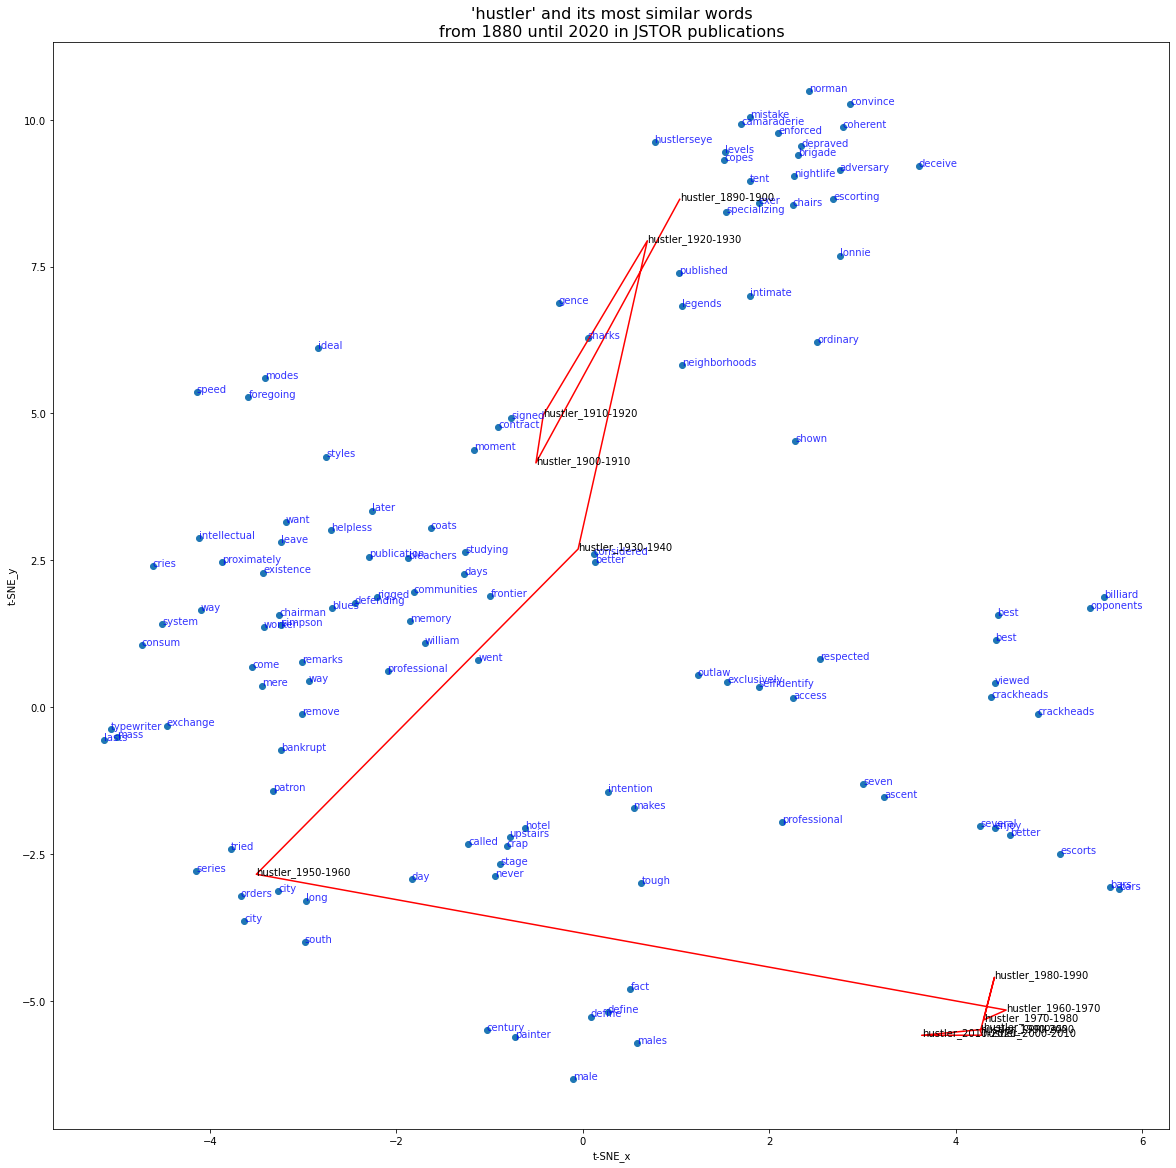

In [247]:
plot_tsne(hustler_mtx_transformed, 'hustler', hustler_idx)

this is all nice and fancy, but it seems the biggest changes in the meaning of a word occur for those time periods in which we have fewer documents available (i.e. individual documents are more able to 'jerk' around and determine the vectors of the respective words). let's check this by using two measures of semantic change ('global' and 'local'; see "Cultural Shift or Linguistic Drift? Comparing Two Computational Measures of Semantic Change" William L. Hamilton, Jure Leskovec, Dan Jurafsky; for the algorithm and the mathematical formula see the paper: https://www.aclweb.org/anthology/D16-1229/) and map the semantic changes of our keywords over time against the relative difference of the number of documents over the same time.

In [12]:
def most_similar_t(word, model, topn=25):
    '''for the method by Hamilton et. al'''
    lst = model.wv.similar_by_vector(word, topn=topn)
    return np.array([similarity for word, similarity in lst])

In [14]:
# quick test, all good
most_similar_t('hustler', model)

array([0.6784094 , 0.66913331, 0.64558405, 0.62231702, 0.59535682,
       0.58401257, 0.58007687, 0.57463163, 0.57043052, 0.56512821,
       0.5634703 , 0.5604443 , 0.5508675 , 0.54747409, 0.54363734,
       0.54174769, 0.54045367, 0.54015625, 0.54011804, 0.53902626,
       0.53629684, 0.53627795, 0.53561729, 0.53468585, 0.53014666])

In [15]:
directory = r'C:\Users\jackewiebohne\Documents\python tests\DTA\model'
words = ['hustles', 'hustled', 'hustle', 'hustler', 'hustlers', 'hustling']

abs_dict = {} # will simply take the vectors of the keywords
rel_dict = {}
t = 0 # for the time layers
exceptions = []
for file in pl.Path(directory).iterdir():
    if file.is_file():
        name = get_filename(file)
        if name != 'log' and name != 'compass.model':
            t += 1
            model = Word2Vec.load(str(file))
            for word in words:
                if word not in exceptions:
                    try:
                        abs_dict[word + str(t)] = model.wv[word]
                        rel_dict[word + str(t)] = most_similar_t(word, model, topn=10)
                    except:
                        # we will only use the words which for which we have complete data over all decades, all others are removed
                        exceptions.append(word)
                        for i in range(t+1):
                            try:
                                del abs_dict[word + str(i)]
                                del rel_dict[word + str(i)]
                            except:
                                print('previous already removed')

previous already removed
previous already removed
previous already removed
previous already removed
previous already removed
previous already removed
previous already removed
previous already removed
previous already removed
previous already removed


In [16]:
print(exceptions)

['hustles', 'hustle', 'hustlers', 'hustler', 'hustled']


In [17]:
# print(abs_dict)
# print(rel_dict)

In [18]:
abs_diff = []
rel_diff = []
for t in range(1,13):
    abs_diff.append(cosinesim(abs_dict['hustling' + str(t)], abs_dict['hustling' + str(t+1)]))
    rel_diff.append(cosinesim(rel_dict['hustling' + str(t)], rel_dict['hustling' + str(t+1)]))
print(abs_diff)
print(rel_diff)

[0.98704183, 0.9742691, 0.97528553, 0.9660048, 0.96700054, 0.9787602, 0.5676241, 0.7692491, 0.8412503, 0.8506559, 0.86976403, 0.8304695]
[0.9999999364723157, 0.999997061761298, 0.9999984899834974, 0.999999598870192, 0.9999991829056952, 0.9999994534843651, 0.9994954506607576, 0.999878224629008, 0.9996858720808279, 0.9998577622914097, 0.9999040310672386, 0.9999319302141036]


In [19]:
x = np.argsort(abs_diff)
y = np.argsort(rel_diff)
print(x)
print(y)
print(np.corrcoef(abs_diff,rel_diff))

[ 6  7 11  8  9 10  3  4  1  2  5  0]
[ 6  8  9  7 10 11  1  2  4  5  3  0]
[[1.         0.90171299]
 [0.90171299 1.        ]]


In [20]:
df1k = pd.read_excel('./JSTOR data/topgram_geo2.xlsx', engine='openpyxl')
bins = [1880,1890,1900, 1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020]
df1k['bins'] = pd.cut(df1k['date'], bins)
docs_per_date = df1k['bins'].value_counts().sort_index() 

diff_per_date = []
for t in range(1,len(docs_per_date.values)):
    if t < 13:
        diff_per_date.append(docs_per_date.values[t] - docs_per_date.values[t+1])
    
print(docs_per_date)
print(diff_per_date)

(1880, 1890]      0
(1890, 1900]      3
(1900, 1910]      9
(1910, 1920]     17
(1920, 1930]     12
(1930, 1940]      7
(1940, 1950]      2
(1950, 1960]      8
(1960, 1970]     44
(1970, 1980]    164
(1980, 1990]    147
(1990, 2000]    219
(2000, 2010]    221
(2010, 2020]    147
Name: bins, dtype: int64
[-6, -8, 5, 5, 5, -6, -36, -120, 17, -72, -2, 74]


In [21]:
print(np.corrcoef(abs_diff,diff_per_date))
print(np.corrcoef(rel_diff,diff_per_date))
print(np.corrcoef(abs_diff,docs_per_date.values[1:-1]))
print(np.corrcoef(rel_diff,docs_per_date.values[1:-1]))

[[1.         0.33624324]
 [0.33624324 1.        ]]
[[1.         0.21567673]
 [0.21567673 1.        ]]
[[ 1.         -0.22931199]
 [-0.22931199  1.        ]]
[[ 1.         -0.18768419]
 [-0.18768419  1.        ]]


turns out the worries are unwarranted